# SALES PREDICTION USING REGRESSION MODEL

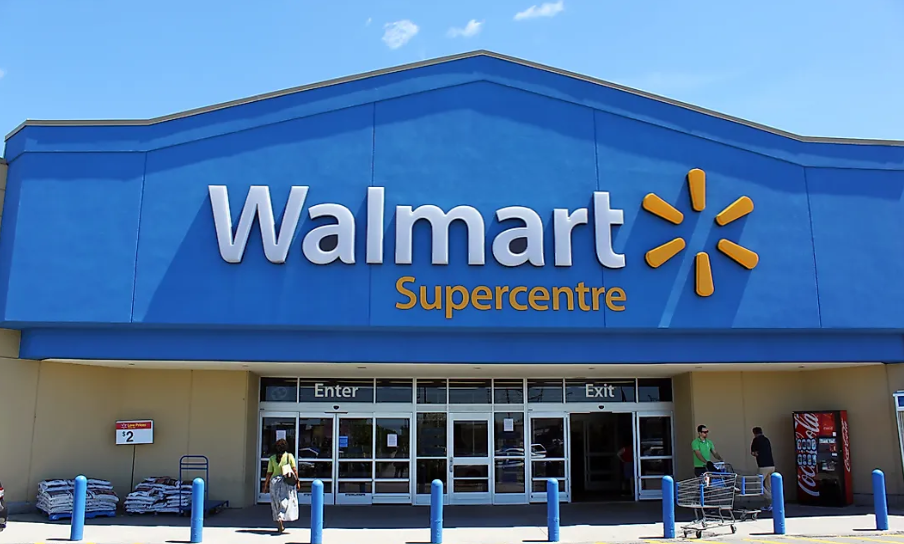

   Walmart is a multinational retail company operating a chain of grocery stores, discount department stores, and hypermarkets. The company was founded in 1962 by Sam Walton and incorporated in 1969. It is headquartered in Bentonville, Arkansas, and has outlets in almost all parts of the world. From a humble beginning in Rogers, Arkansas, Walmart has expanded and currently runs 11,348 retail units under 58 banners in around 27 countries. Most of the retail stores operate under different names. Today, the retail company is the largest in the world by revenue and also the largest private employer with over 2 million employees worldwide.

**Walmart Locations Around The World:**
* **The United States**

The United States has the highest number of Walmart stores in the world, boasting of 5,358 retail units. Walmart US is the largest division of Walmart, accounting for about 65% of the company’s sale (2019).

* **Mexico**

Walmart’s division in Mexico is the largest outside of the United with up to 2468 stores. The company’s division in Mexico is known as Walmex or Walmart de Mexico y Centroamerica. Walmart stores in the country include 277 supercenter stores, Bodega Aurrera (located in 526 locations).

* **The United Kingdom**

Walmart retails in the UK as Asda (a company acquired by Walmart in 1999). The company is headquartered in Leeds and has 633 stores across the country. Asda stores were and remain grocery stores and have a strong focus on non-food items compared to other stores across the country.

* **African Countries**

Walmart entered the African market following the acquisition of South Africa’s Massmart Holding Limited in 2010. Today, there are 442 Walmart stores across Africa, of which 394 stores are in South Africa but under different banners. Botswana has 11 stores, also under different banners such as Game Foodco, CBW, and Builders Warehouse.

# 1. Import Libraries and Code Preparation (define function and data)

## 1.1 Import Libraries

In [1]:
#libraries for data analysis
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import datetime
from datetime import timedelta
import holidays
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.api import qqplot

#libraries for data visualization
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px

#machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate

#machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

#matrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

import warnings
warnings.filterwarnings("ignore")


## 1.2 Preparation

### 1.2.1 Create Categorical Customize Dtypes

In [2]:
#name of the month order
monthly_cat = CategoricalDtype(categories=['January',
                                           'February',
                                           'March',
                                           'April',
                                           'May',
                                           'June',
                                           'July',
                                           'August',
                                           'September',
                                           'October',
                                           'November',
                                           'December'], ordered=True)

#name of the day order
daily_cat = CategoricalDtype(categories=['Sunday',
                                         'Monday',
                                         'Tuesday',
                                         'Wednesday',
                                         'Thursday',
                                         'Friday',
                                         'Saturday'], ordered=True)


### 1.2.2 Create Helpfull Function

In [3]:
#function fo get the values of datetime object
def expand_date(df, datetime_col : 'str'):
  df = df.copy()
  df['Day'] = df[datetime_col].dt.day
  df['Month'] = df[datetime_col].dt.month
  df['Year'] = df[datetime_col].dt.year
  df['Month_Name'] = df[datetime_col].dt.month_name()
  df['Month_Name'] = df['Month_Name'].astype(monthly_cat)
  df['Day_Name'] = df[datetime_col].dt.day_name()
  df['Day_Name'] = df['Day_Name'].astype(daily_cat)
  df['Week_of_Year'] = df[datetime_col].dt.isocalendar().week
  df['Day_of_Year'] = df[datetime_col].dt.dayofyear
  df['Quarter'] = df[datetime_col].dt.quarter

  return df

In [4]:
#function to check Null values
def check_null(df, only_null : bool = False):
    res = pd.DataFrame({
        'Null_QTY' : df.isnull().sum(),
        '%Null' : 100*df.isnull().sum()/len(df)
    })
    
    if only_null:
        if len(res[res['Null_QTY']>0])==0:
            print("There's no Null values in DataFrame")
        else:
            return res[res['Null_QTY']>0]
    else:
        return res

In [5]:
def stationary_test(data, p_val = 0.05):
    adfuller_results = adfuller(data)
    print('ADF Statistic : {:.2f}'.format(adfuller_results[0]))
    print('ADF p-value : {:.2f}'.format(adfuller_results[1]))
    print('ADF lag-used : {}'.format(adfuller_results[2]))
    print('n observasion : {}'.format(adfuller_results[3]))
    print('Critical Values:')
    for key, value in adfuller_results[4].items():
        print('\t{}: {}'.format(key, value))
    print('='*50)
    print('Conclution:')       
    if adfuller_results[1] < p_val:
        print('Time Series is Stationary')
    else:
        print('Time Series is Not-Stationary')

In [6]:
#see validation score of Model
def see_val_score(cv_scores_result, model_name = None, figsize=(10,9)):
    
    #create dataframe of scoring
    scdf = pd.DataFrame(cv_scores_result)
    
    #drop irrelevant values based on R^2
    scdf.drop(index=scdf[(scdf['test_r2']>1)|(scdf['test_r2']<0)].index, inplace=True)
    scdf.reset_index(drop=True, inplace=True)
    scdf.rename(columns={
        'test_r2' : 'R-Squared',
        'test_neg_mean_absolute_error':'MAE',
        'test_neg_root_mean_squared_error':'RMSE',
        'test_neg_mean_absolute_percentage_error':'MAPE',
    }, inplace=True)
    
    #turn negative value in to positive
    scdf['MAE'] = -scdf['MAE']
    scdf['RMSE'] = -scdf['RMSE']
    scdf['MAPE'] = -scdf['MAPE']
    
    if model_name != None:
        scdf['Model'] = model_name
        scdf = scdf[['Model','fit_time','score_time','R-Squared','MAE','RMSE','MAPE']]
     
    #plot result
    f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=figsize)
    
    #plot R^2 values
    sns.boxplot(scdf.loc[:,'R-Squared'], ax=ax1)
    ax1.set_title('R-Squarred Validation Distribution', size=int(figsize[0]*1.4))
    
    #plot scoring values MAPE
    sns.boxplot(scdf.loc[:,'MAPE'], ax=ax2)
    ax2.set_title('MAPE Validation Result', size=int(figsize[0]*1.4))

    #plot scoring values MAE and RMSE
    sns.barplot(scdf.loc[:,['MAE','RMSE']], ax=ax3)
    ax3.set_title('MAE and RMSE Validation Result', size=int(figsize[0]*1.4))
    
    #recapt all plot
    f.suptitle('Validation Score Result Plot', size=int(figsize[0]*2))
    f.tight_layout()
    plt.plot();
    
    #save result
    return scdf

In [7]:
def test_result(y_pred, y_act, title='Testing Result'):
  f, ax = plt.subplots(2,2, figsize = (8,8))

  sns.histplot(y_pred-y_act, label = 'Residual', ax = ax[0,0])
  sns.kdeplot(y_pred, color = 'b', label = 'Predicted_Sales', ax = ax[0,1])
  sns.kdeplot(y_act, color = 'g', label = 'Actual_Sales', ax = ax[0,1])
  qqplot(data=(y_pred-y_act), line='45', fit=True,
         ax=ax[1,0])
  sns.regplot(x = y_act, y = y_pred,
              scatter_kws =  dict(marker = '.', color = 'b', s = 2, alpha = .5),
              line_kws = dict(color = 'b', linestyle = '--', lw = 1), ax = ax[1,1])

  f.suptitle(title)
  ax[0,0].set_title('Residual Distribution')
  ax[0,1].set_title('Predicted vs Actual Sales Distribution')
  ax[0,1].legend()
  ax[1,0].set_title('QQ-Plot')
  ax[1,1].set_title('Predicted vs Actual Sales')
  f.tight_layout()
  plt.show();

In [8]:
#function to evalute matric of model

#create evaluation matrics scorecard function
def evaluation_matrics(y_pred, y_act, title = 'Evaluation Matrics Scores'):
  print(title)
  print('=='*20)
  print('RMSE : {:.2f}'.format(np.sqrt(MSE(y_act, y_pred))))
  print('MAE  : {:.2f}'.format(MAE(y_act, y_pred)))
  print('MAPE : {:.2f}'.format(MAPE(y_act, y_pred)))

#combine evaluation matrics with evaluation plot
def model_evaluation(y_pred, y_act, title = 'Evaluation Matrics Scores'):
  evaluation_matrics(y_pred, y_act)
  scdf = test_result(y_pred, y_act)
  return scdf

In [9]:
#funtion to plot test result on plot, and return the dataframe
def return_test_result(test_keys=None, test_features=None, y_test=None, ypred_test=None, columns = None, pred_column='Pred_Weekly_Sales', plot=False, future_pred=True):
    if future_pred:
        res = np.concatenate([test_keys, test_features, ypred_test.reshape(-1,1)], axis=1)
        res_df = pd.DataFrame(res, columns=columns+[pred_column])
    else:
        res = np.concatenate([test_keys, test_features, y_test.reshape(-1,1), ypred_test.reshape(-1,1)], axis=1)
        res_df = pd.DataFrame(res, columns=columns+[pred_column])       
    
    if plot:
        if future_pred:
            res_df[['Date', pred_column]].groupby('Date').sum()\
                .plot(title='Predicted Weekly Sales Plot', color='b')  
            
        else:
            res_df[['Date', pred_column,'Weekly_Sales']].groupby('Date').sum()\
                .plot(title='Predicted vs Actual Weekly Sales', color=['b','g'])
    

    return res_df

# 2. Load Dataset

In [10]:
#creating data path
stores_path = '/kaggle/input/walmart-sales-prediction-dataset/stores.csv'
sales_path = '/kaggle/input/walmart-sales-prediction-dataset/sales.csv'
features_path = '/kaggle/input/walmart-sales-prediction-dataset/features.csv'

#create pandas dataframe object
stores_df = pd.read_csv(stores_path)
features_df = pd.read_csv(features_path)
sales_df = pd.read_csv(sales_path)

# 3. Explore Dataset

## 3.1 Store Dataset

### 3.1.1 Explore Globaly

In [11]:
#see the dataset
stores_df.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

In [12]:
#see the general information of dataset
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [13]:
#check for duplicated values
stores_df.duplicated().sum()

0

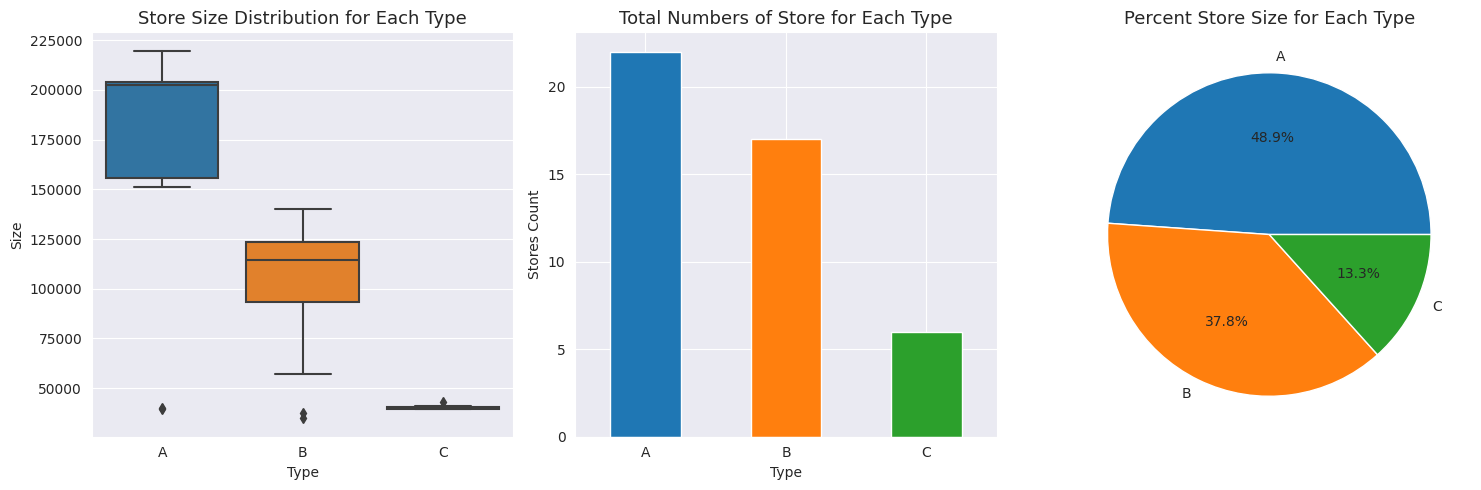

In [14]:
#visualize plot
stores_type_count = stores_df.groupby(by = 'Type')['Size'].count()

f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15, 5))

sns.boxplot(stores_df, x = 'Type', y = 'Size',  palette = 'tab10', ax = ax1)
stores_type_count.plot(kind = 'bar', color = sns.color_palette('tab10')[:3], ax = ax2)
ax3.pie(stores_type_count, labels = stores_type_count.index, autopct='%1.1f%%')


ax1.set_title('Store Size Distribution for Each Type', size=13)
ax2.set_title('Total Numbers of Store for Each Type', size=13)
ax2.set_ylabel('Stores Count')
ax2.set_xticklabels(labels=ax2.get_xticklabels(), rotation=0)
ax3.set_title('Percent Store Size for Each Type', size=13)


f.tight_layout()
#plt.savefig('stores_analysis.png')

### 3.1.2 Insights

insight:
* There are 3 types of stores, Type A, Type B, and Type C Stores
* Type A stores is the biggest store by size, it also has more than 20 stores recorded. Type B is smaller than Type A but bigger than Type C, it has 15-20 stores recorded. And Type C store is the smallest, it only has 6 numbers of stores recorded.
* Normallny, the size distribution of stores doesn't overlapping. But only small fraction of stores does.

## 3.2 Features Dataset

### 3.2.1 Explore Globaly

In [15]:
#take a look on features dataframe
features_df.head()

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  05/02/2010        42.31       2.572        NaN        NaN   
1      1  12/02/2010        38.51       2.548        NaN        NaN   
2      1  19/02/2010        39.93       2.514        NaN        NaN   
3      1  26/02/2010        46.63       2.561        NaN        NaN   
4      1  05/03/2010        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False

In [16]:
#see features information
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


* `Date` is in object dtypes, we need to change it datetime object so we can analyze it quickly by utilizing Pandas Datetime function
* it seems that `features_df` has a lot of null values, lets do quick check of null values

In [17]:
check_null(features_df)

Null_QTY      %Null
Store                0   0.000000
Date                 0   0.000000
Temperature          0   0.000000
Fuel_Price           0   0.000000
MarkDown1         4158  50.769231
MarkDown2         5269  64.334554
MarkDown3         4577  55.885226
MarkDown4         4726  57.704518
MarkDown5         4140  50.549451
CPI                585   7.142857
Unemployment       585   7.142857
IsHoliday            0   0.000000

* around 50-64% of MarkDown data are missing
* we also miss 7% of CPI and unemployment data

In [18]:
#convert 'Date' column into datetime data types
features_df['Date'] = pd.to_datetime(features_df['Date'], dayfirst=True)

#set 'Date' into index
features_df.set_index('Date', drop = True, inplace=True)

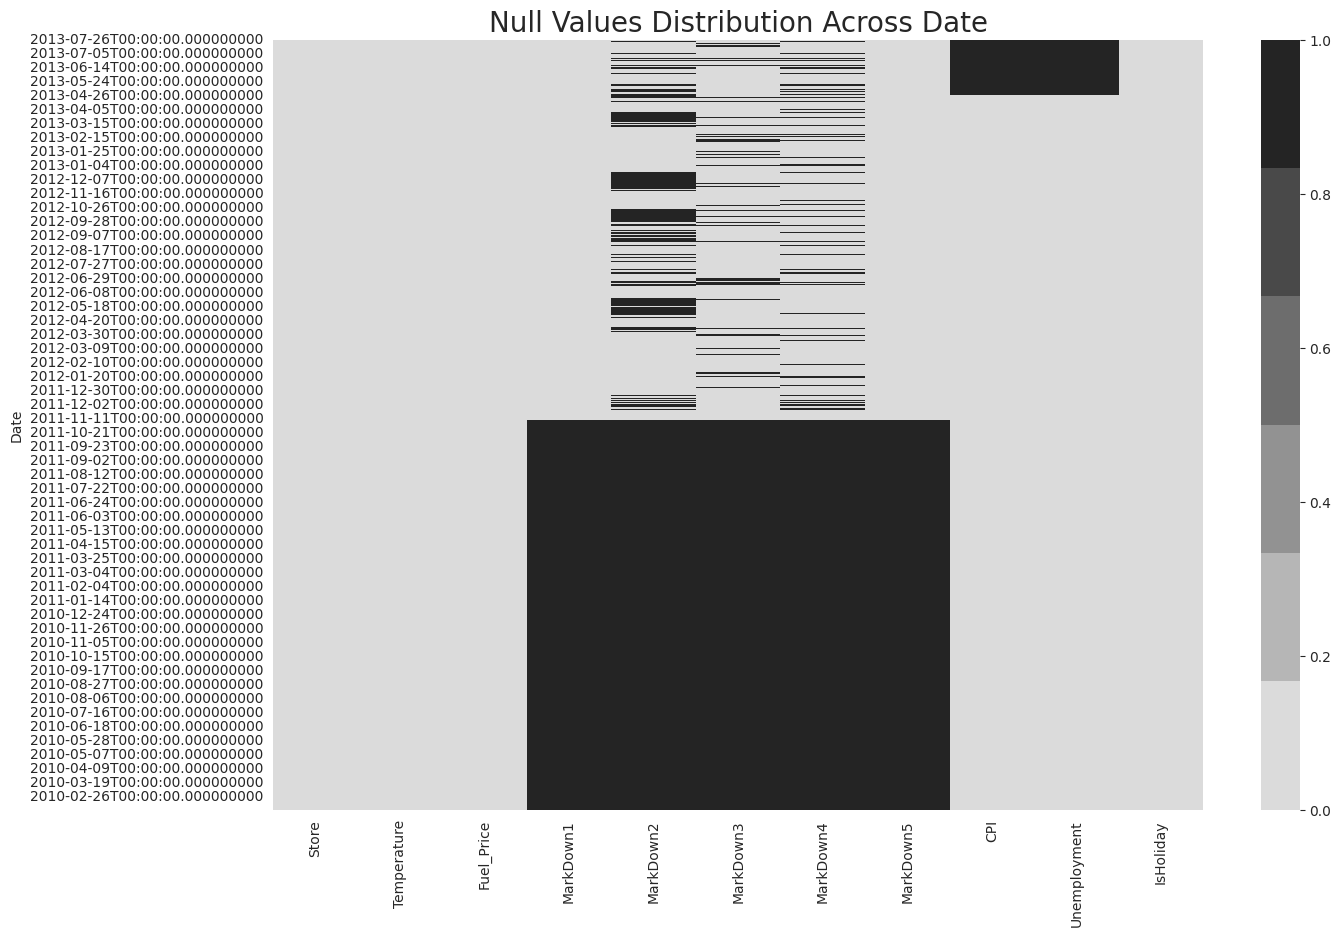

In [19]:
#lets visualize null values over time using Heatmap plot
f, ax = plt.subplots(1,1,figsize = (15,10))
sns.heatmap(features_df.sort_index(ascending=False).isnull(),
            linecolor = 'white', cmap = sns.color_palette('binary'), ax=ax)
plt.title('Null Values Distribution Across Date', size = 20)
plt.show();

* almost all of MarkDown1-5 are missing from January 2010 to Desember 2011
* all of CPI and Unemployment data are missing are distributed on March 2013 to November 2013

In [20]:
#see the statistical summary of dataset
features_df.describe().T

count         mean           std       min          25%  \
Store         8190.0    23.000000     12.987966     1.000    12.000000   
Temperature   8190.0    59.356198     18.678607    -7.290    45.902500   
Fuel_Price    8190.0     3.405992      0.431337     2.472     3.041000   
MarkDown1     4032.0  7032.371786   9262.747448 -2781.450  1577.532500   
MarkDown2     2921.0  3384.176594   8793.583016  -265.760    68.880000   
MarkDown3     3613.0  1760.100180  11276.462208  -179.260     6.600000   
MarkDown4     3464.0  3292.935886   6792.329861     0.220   304.687500   
MarkDown5     4050.0  4132.216422  13086.690278  -185.170  1440.827500   
CPI           7605.0   172.460809     39.738346   126.064   132.364839   
Unemployment  7605.0     7.826821      1.877259     3.684     6.634000   

                      50%          75%            max  
Store           23.000000    34.000000      45.000000  
Temperature     60.710000    73.880000     101.950000  
Fuel_Price       3.513000     3.743000       4.468000  
MarkDown1     4743.580000  8923.310000  103184.980000  
MarkDown2      364.570000  2153.350000  104519.540000  
MarkDown3       36.260000   163.150000  149483.310000  
MarkDown4     1176.425000  3310.007500   67474.850000  
MarkDown5     2727.135000  4832.555000  771448.100000  
CPI            182.764003   213.932412     228.976456  
Unemployment     7.806000     8.567000      14.313000

In [21]:
#check for duplicated
features_df.duplicated().sum()

0

there's no duplicated row in `feature_df`

### 3.2.2 Explore Each Feature in `features_df`

#### 3.2.2.1 Temperature

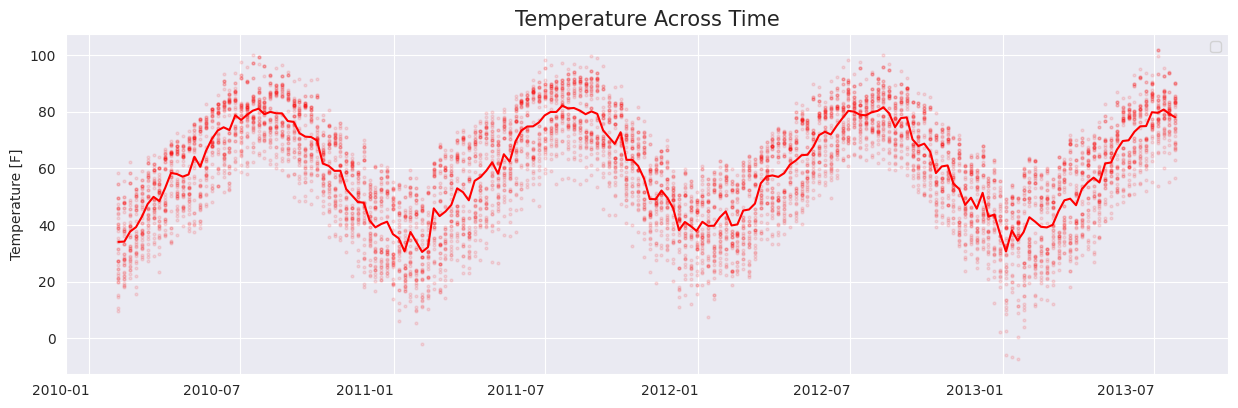

In [22]:
f, ax = plt.subplots(1,1,figsize=(15, 5))

features_df['Temperature'].plot(style='.', ms=4,
                                alpha=.1, color='r', ax=ax)
sns.lineplot(features_df['Temperature'],
             color = 'r', errorbar = None, ax=ax)

plt.xticks(rotation=0)
plt.title('Temperature Across Time', size=15)
plt.ylabel('Temperature [F]')
plt.xlabel('')
plt.legend('')

#plt.savefig('temperature_across_time.png')

plt.show();

#### 3.2.2.2 Fuel Price

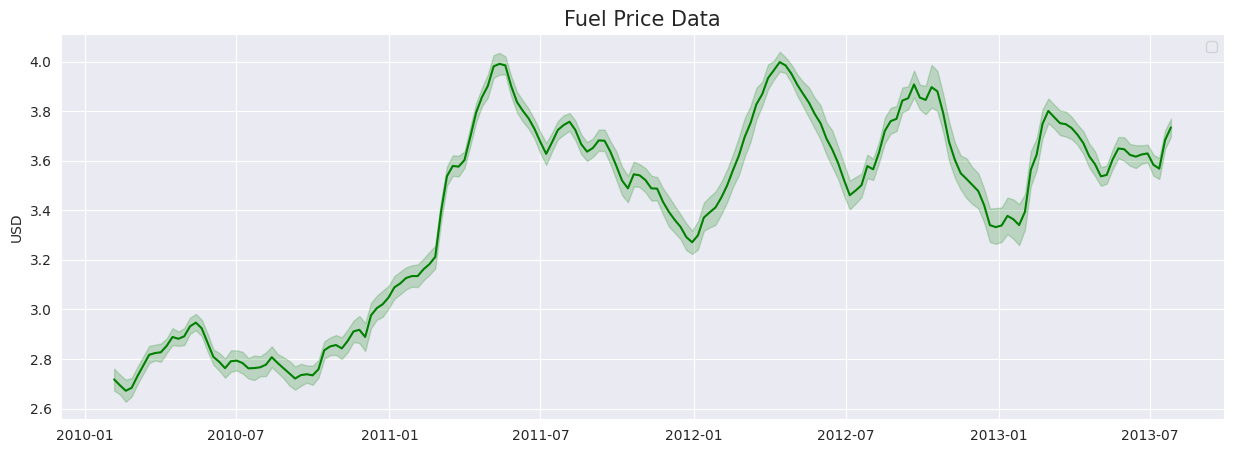

In [23]:
f, ax = plt.subplots(1,1,figsize=(15, 5))

sns.lineplot(features_df['Fuel_Price'],
             color = 'g', ax=ax)

plt.title('Fuel Price Data', size=15)
plt.ylabel('USD')
plt.xlabel('')
plt.legend('')

#plt.savefig('fuel_price_data.png')

plt.show();

#### 3.2.2.3 MarkDowns

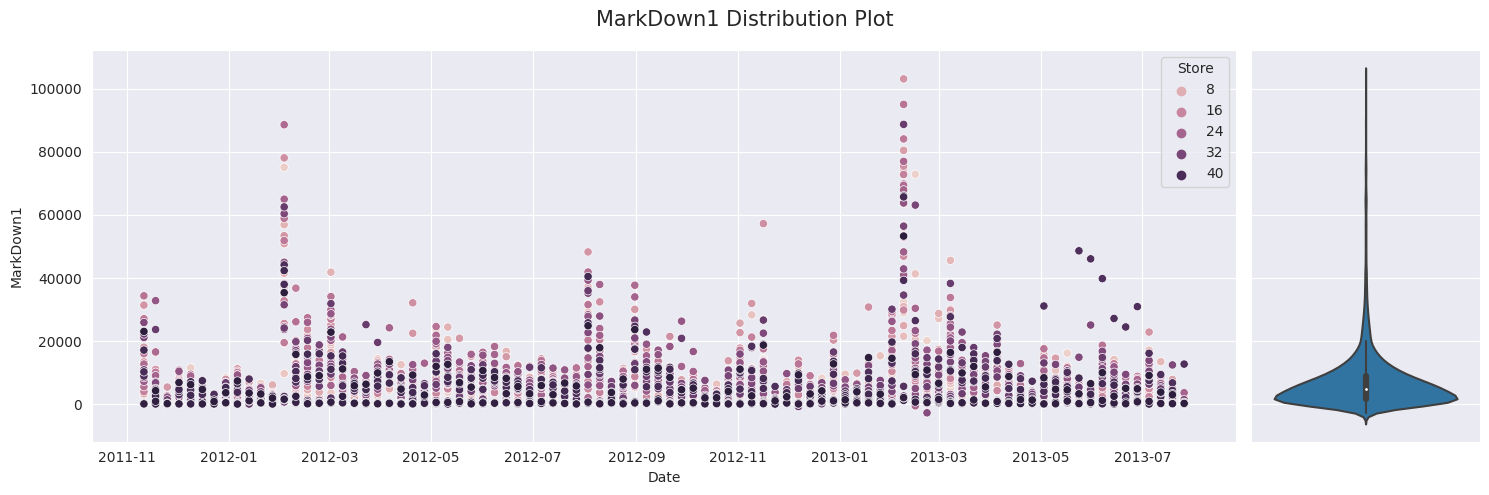

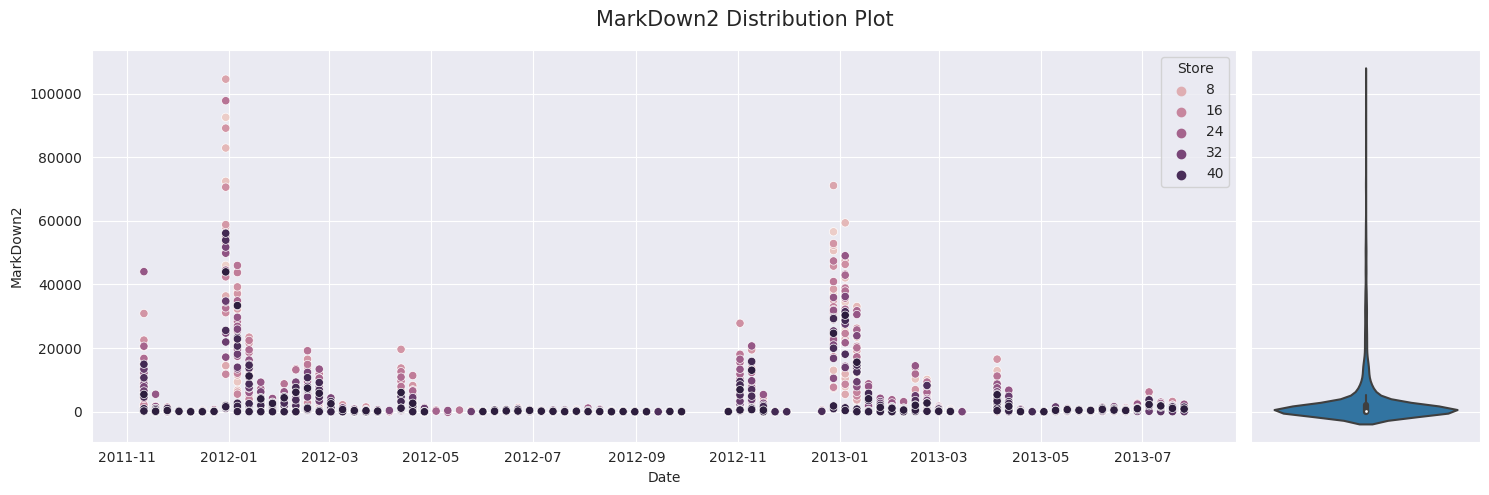

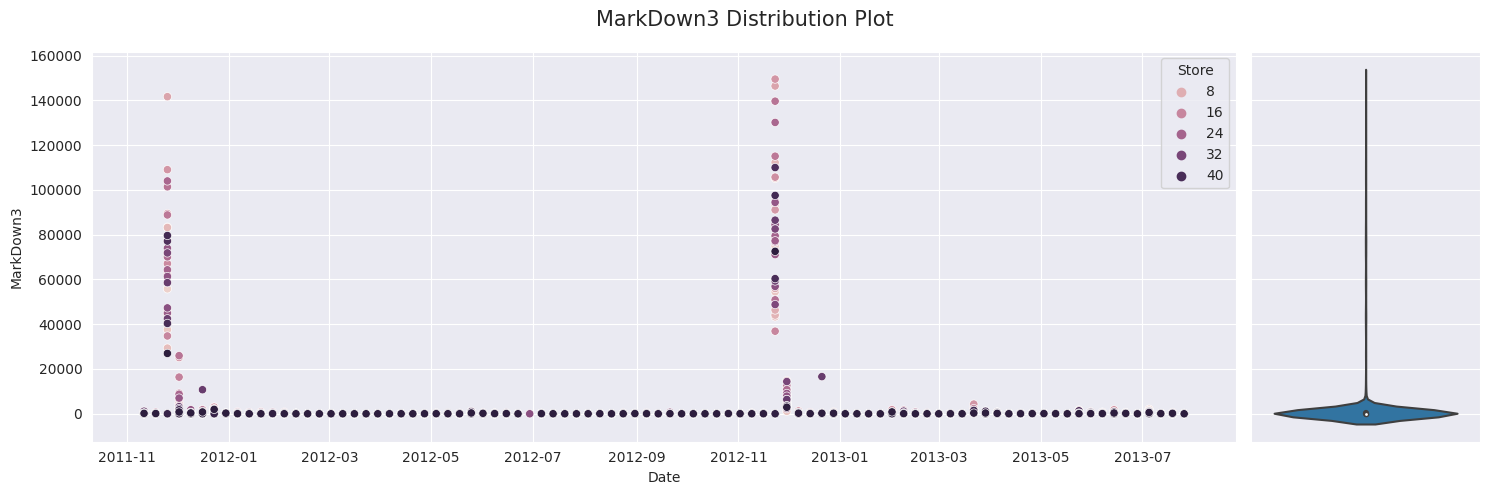

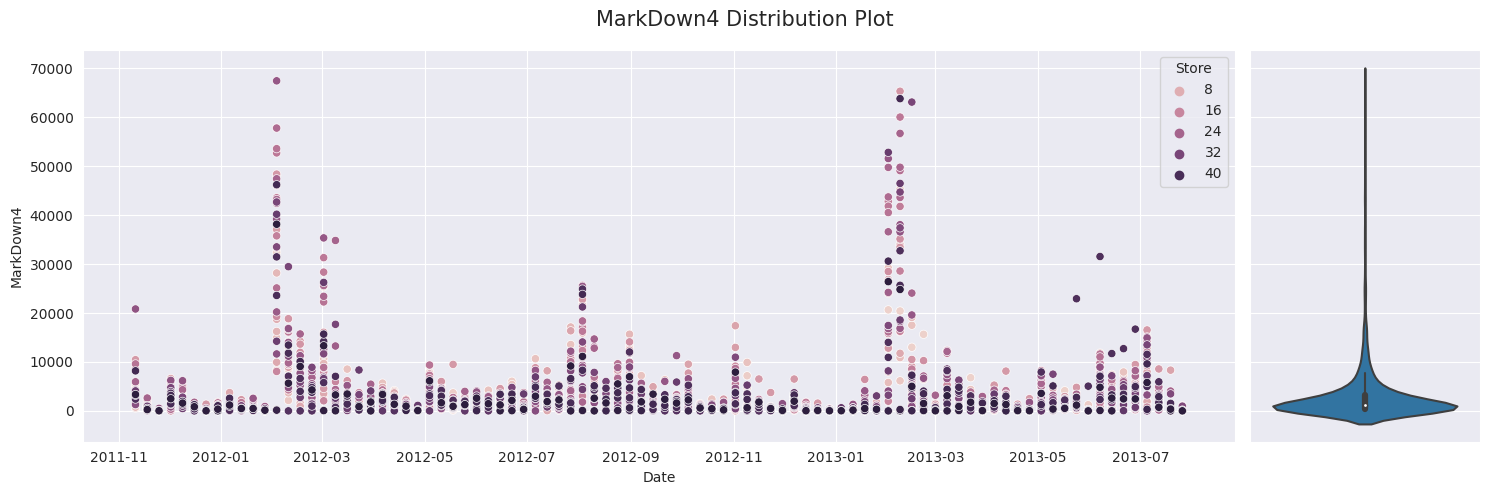

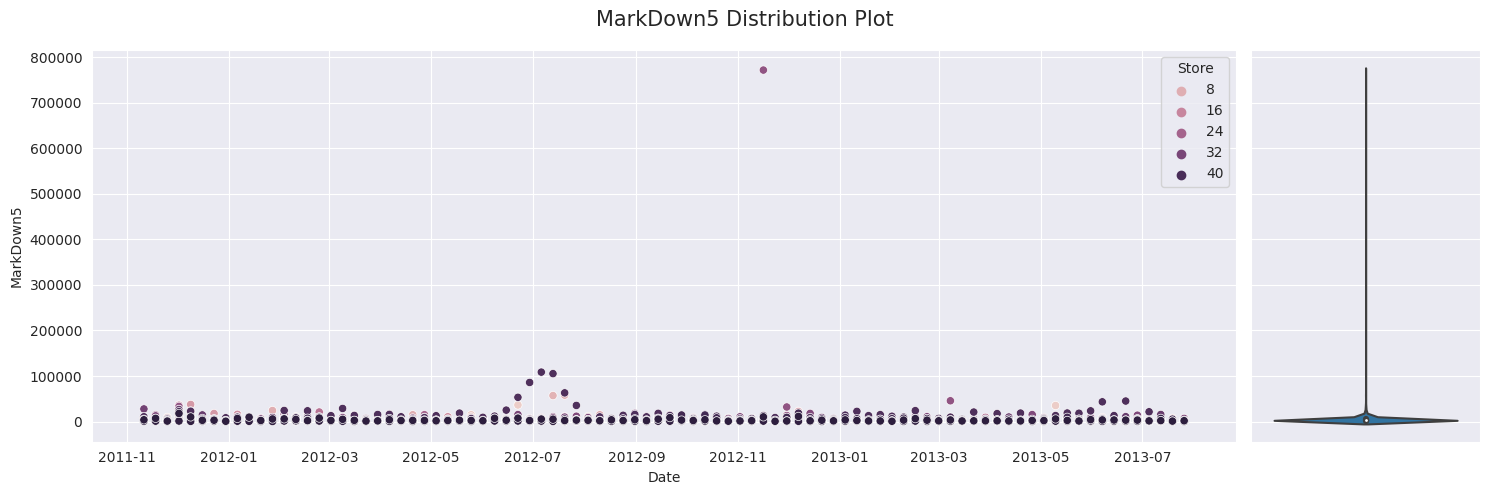

In [24]:
for i in features_df.columns[3:8]:
    f, (ax1,ax2) = plt.subplots(1,2, figsize = (15,5), gridspec_kw={'width_ratios': [5, 1]}, sharey = True)
    sns.scatterplot(features_df, x = 'Date', y = i, color = 'k', hue = 'Store', ax = ax1)
    sns.violinplot(features_df, y = i, fill = False, ax = ax2)
    
    plt.xticks(rotation = 90, size = 8)
    ax2.set_ylabel('')
    f.suptitle(f'{i} Distribution Plot', size=15)
    f.tight_layout()
    #plt.savefig(f'{i} Distribution_Plot.png')
    plt.show()


#### 3.2.2.4 Customer's Price Index (CPI)

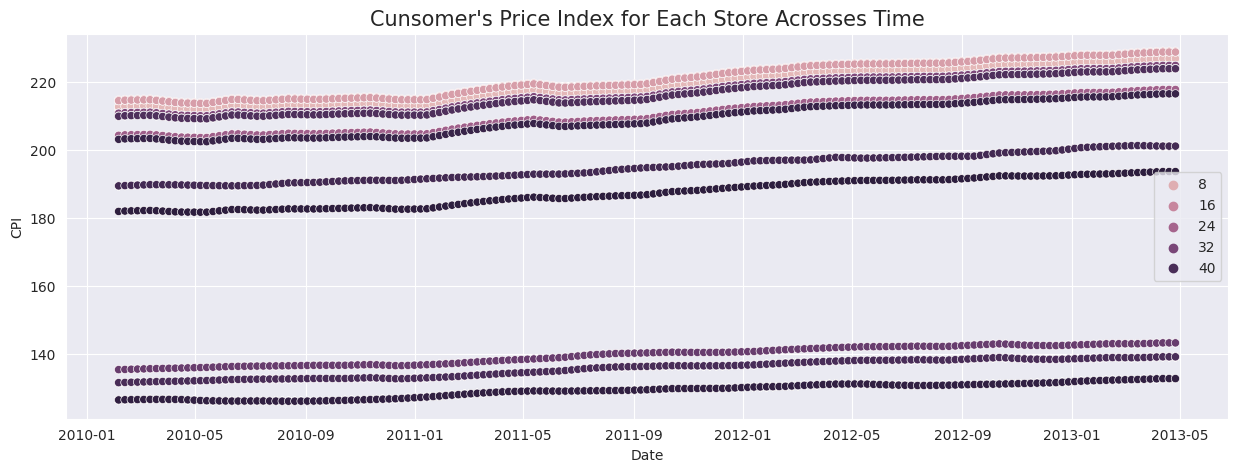

In [25]:
f, ax = plt.subplots(1,1,figsize=(15, 5))

sns.scatterplot(features_df, x=features_df.index, y='CPI', hue = 'Store', ax=ax)

plt.title("Cunsomer's Price Index for Each Store Acrosses Time", size=15)
plt.legend()


plt.savefig("Cunsomer's_Price_Index.png")
plt.show();

#### 3.2.2.5 Unemployment

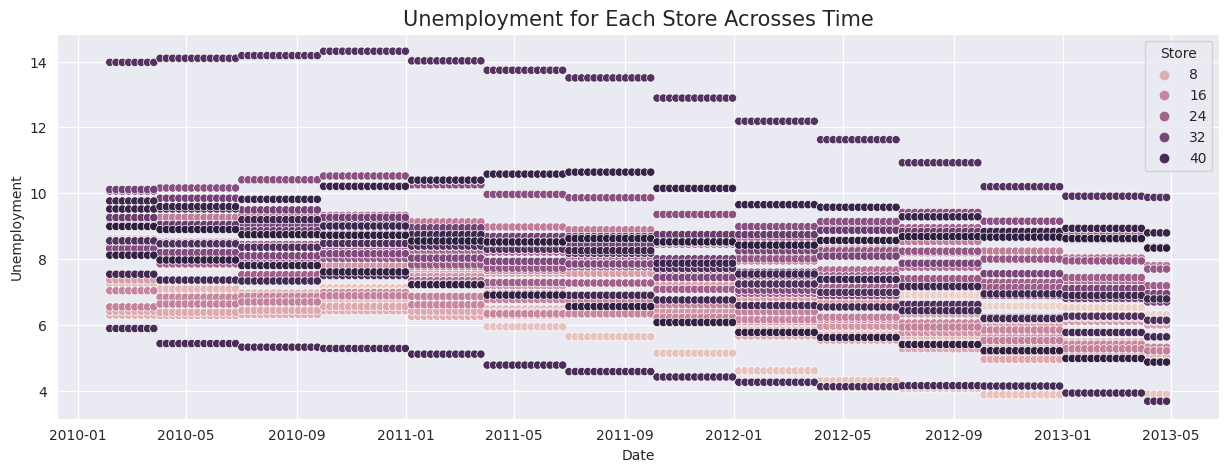

In [26]:
f, ax = plt.subplots(1,1, figsize = (15,5))
                     
sns.scatterplot(features_df, x=features_df.index, y='Unemployment', hue = 'Store', ax=ax)

plt.title("Unemployment for Each Store Acrosses Time", size=15)
#plt.savefig("unemployment.png")
plt.show();

## 3.3 Sales Dataset

### 3.3.1 Explore Globaly

In [27]:
sales_df.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  05/02/2010      24924.50      False
1      1     1  12/02/2010      46039.49       True
2      1     1  19/02/2010      41595.55      False
3      1     1  26/02/2010      19403.54      False
4      1     1  05/03/2010      21827.90      False

In [28]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [29]:
#check for statistic of sales_df2
sales_df.describe().T

count          mean           std      min      25%      50%  \
Store         421570.0     22.200546     12.785297     1.00    11.00    22.00   
Dept          421570.0     44.260317     30.492054     1.00    18.00    37.00   
Weekly_Sales  421570.0  15981.258123  22711.183519 -4988.94  2079.65  7612.03   

                     75%        max  
Store            33.0000      45.00  
Dept             74.0000      99.00  
Weekly_Sales  20205.8525  693099.36

There's minus sales, sales data can not be negative values. we can drop sales data which has negative values

In [30]:
#drop negative value sales
sales_df.drop(sales_df[sales_df['Weekly_Sales']<0].index, axis=0,
              inplace=True)

In [31]:
#check for statistic of sales_df
sales_df.describe().T

count          mean           std  min      25%      50%  \
Store         420285.0     22.195477     12.787213  1.0    11.00    22.00   
Dept          420285.0     44.242771     30.507197  1.0    18.00    37.00   
Weekly_Sales  420285.0  16030.329773  22728.500149  0.0  2117.56  7659.09   

                   75%        max  
Store            33.00      45.00  
Dept             74.00      99.00  
Weekly_Sales  20268.38  693099.36

In [32]:
#check for duplicated values
sales_df.duplicated().sum()

0

### 3.3.2 Sales on Different Store and Department

In [33]:
sales_store_df = sales_df.merge(stores_df, how = 'left')[['Store', 'Type', 'Size', 'Dept', 'Date', 'IsHoliday','Weekly_Sales']]
sales_store_df

Store Type    Size  Dept        Date  IsHoliday  Weekly_Sales
0           1    A  151315     1  05/02/2010      False      24924.50
1           1    A  151315     1  12/02/2010       True      46039.49
2           1    A  151315     1  19/02/2010      False      41595.55
3           1    A  151315     1  26/02/2010      False      19403.54
4           1    A  151315     1  05/03/2010      False      21827.90
...       ...  ...     ...   ...         ...        ...           ...
420280     45    B  118221    98  28/09/2012      False        508.37
420281     45    B  118221    98  05/10/2012      False        628.10
420282     45    B  118221    98  12/10/2012      False       1061.02
420283     45    B  118221    98  19/10/2012      False        760.01
420284     45    B  118221    98  26/10/2012      False       1076.80

[420285 rows x 7 columns]

In [34]:
#create sales map
sales_map = sales_store_df.groupby(by=['Type', 'Store']) \
                .agg({'Size' : 'mean', 'Weekly_Sales' : 'sum'}) \
                .reset_index()

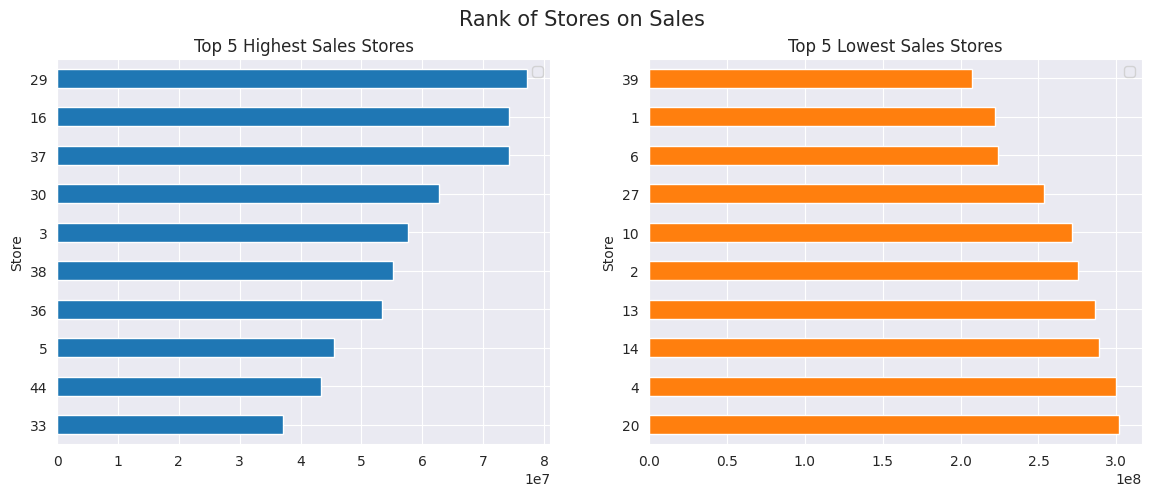

In [35]:
#plot total weekly sales of each stores
f, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))

sales_map.sort_values(by='Weekly_Sales', ascending=True) \
         .iloc[:10,[1,3]] \
         .plot(kind='barh', 
               y='Weekly_Sales', x='Store', 
               color = sns.color_palette('tab10')[0], title = 'Top 5 Highest Sales Stores',
               ax=ax1)

sales_map.sort_values(by='Weekly_Sales', ascending=False) \
         .iloc[:10,[1,3]] \
         .plot(kind='barh', y='Weekly_Sales', x='Store',
               color = sns.color_palette('tab10')[1], title = 'Top 5 Lowest Sales Stores',
               ax=ax2)

ax1.legend('')
ax2.legend('')
f.suptitle('Rank of Stores on Sales', size=15)

#plt.savefig('Rank_of_Stores_on_Sales.png')
plt.show();

In [36]:
#plot the result
fig = px.treemap(sales_map, path=[px.Constant('Sales on Different Stores'), 'Type', 'Store'], values = 'Size',
                 color='Weekly_Sales',
                 color_continuous_scale='RdBu',
                 color_continuous_midpoint=np.median(sales_map['Weekly_Sales']))

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### 3.3.3 Weekly Sales Plot

In [37]:
#convert 'Date' column dtype to datetime object
sales_df['Date'] = pd.to_datetime(sales_df['Date'], dayfirst=True)

#set 'Date' to be index
sales_df.set_index('Date', inplace=True)

In [38]:
#let's grouping data by date to see the plot of sales
weekly_sales_df = sales_df.groupby(by = 'Date').sum().sort_values(by = 'Date', ascending = True)
weekly_sales_df.head()

Store    Dept  Weekly_Sales  IsHoliday
Date                                              
2010-02-05  64962  130137   49750875.98          0
2010-02-12  64897  130734   48336800.10       2949
2010-02-19  65482  131581   48277902.33          0
2010-02-26  64802  129734   43970440.65          0
2010-03-05  64757  129242   46872715.16          0

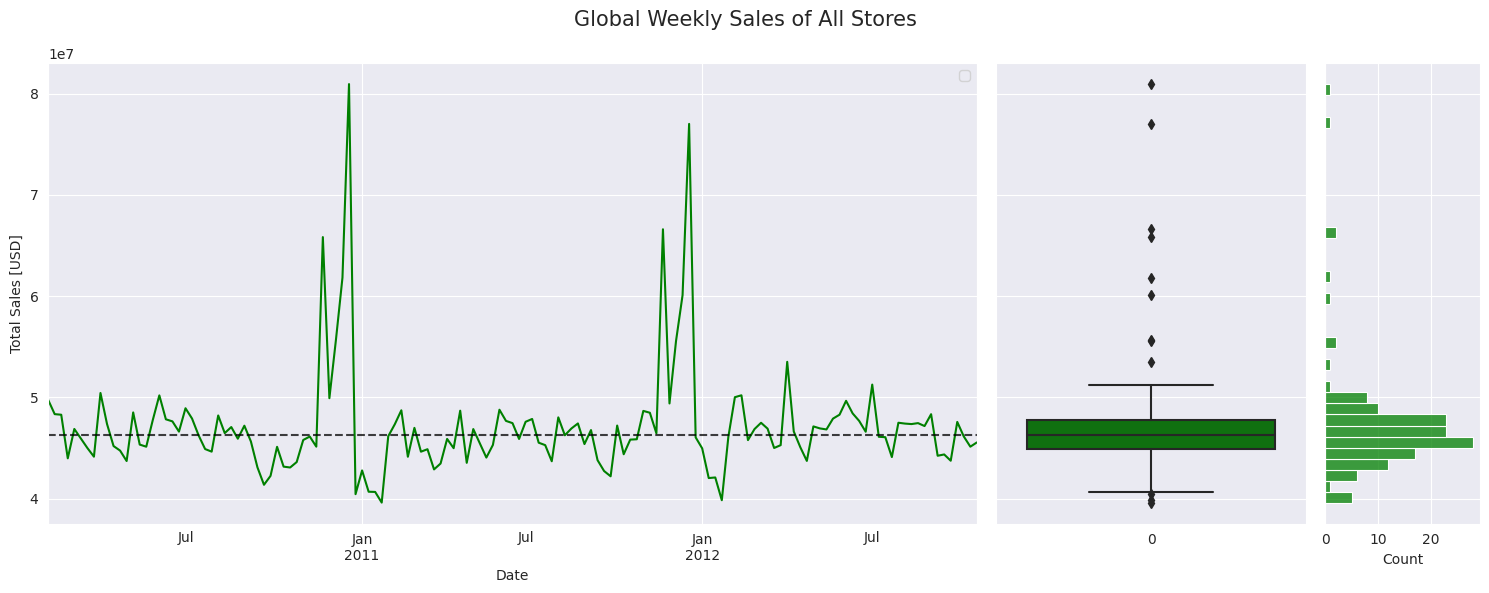

In [39]:
#plot sales
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (15, 6), gridspec_kw={'width_ratios': [3, 1, 0.5]}, sharey = True)

weekly_sales_df['Weekly_Sales'].plot(style = '-', ms = .1, color = 'g',
                                     ylabel = 'Total Sales [USD]', legend = True, ax = ax1)

ax1.axhline(y = weekly_sales_df['Weekly_Sales'].median(),
          linestyle = '--', color = 'k', alpha = .75)

sns.boxplot(weekly_sales_df['Weekly_Sales'], 
            color = 'g', whis = None, ax=ax2)

sns.histplot(weekly_sales_df, y='Weekly_Sales',
             color='g', ax=ax3)

ax1.legend('')
f.suptitle('Global Weekly Sales of All Stores', size=15)
f.tight_layout()
#plt.savefig('./pyplot/Global_Weekly_Sales_All_Stores.png')
#plt.show()

In [40]:
stationary_test(weekly_sales_df['Weekly_Sales'])

ADF Statistic : -5.91
ADF p-value : 0.00
ADF lag-used : 4
n observasion : 138
Critical Values:
	1%: -3.47864788917503
	5%: -2.882721765644168
	10%: -2.578065326612056
Conclution:
Time Series is Stationary


insight:
* There are sales bumps happened on the last Quartal of The Year, especially on October and November. This is might be a caused of some special days happened such as Super Bowl Days, Labor Days, Thanksgiving Days, Christmas Day an so on.
* Sales Time Series is Stationar according to Adfuller Test (p<0.05)

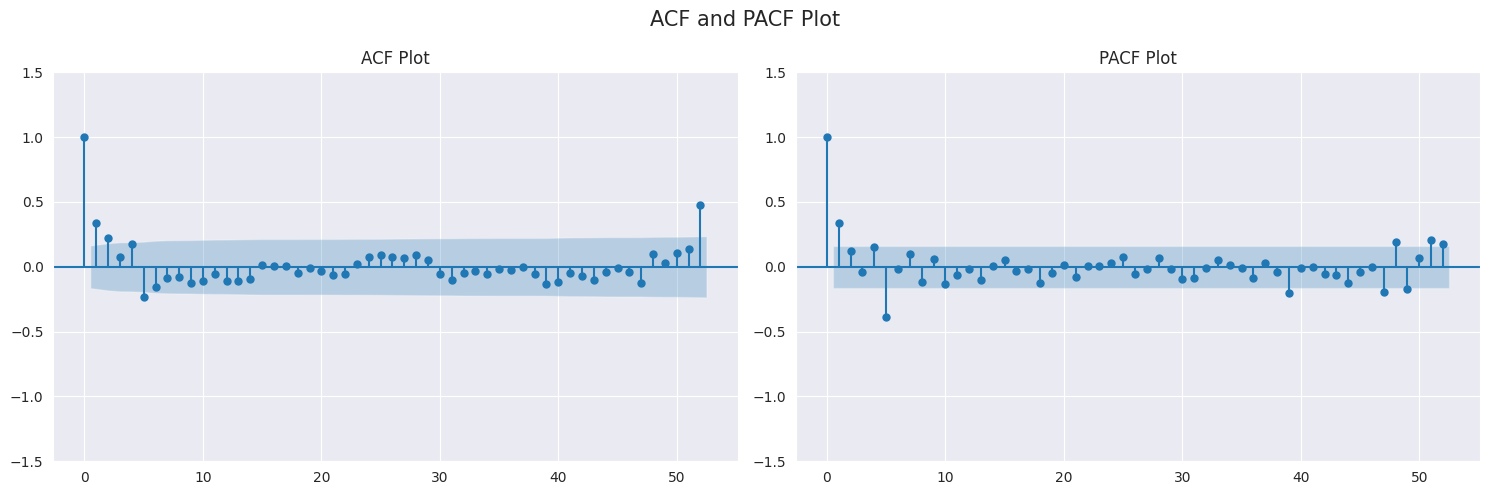

In [41]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

plot_acf(weekly_sales_df['Weekly_Sales'],
        lags = 52,
        title = 'ACF Plot',
        ax = ax1)

plot_pacf(weekly_sales_df['Weekly_Sales'],
          lags = 52,
          title = 'PACF Plot',
          ax = ax2)

ax1.set_ylim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
plt.subplots_adjust(wspace = 1)

f.suptitle('ACF and PACF Plot', size=15)
f.tight_layout()
plt.show()

### 3.3.4 Weekly Sales Seasonal Component

In [42]:
#expand data
weekly_sales_comp_df = expand_date(sales_df.reset_index(), datetime_col='Date')
weekly_sales_comp_df.head()

Date  Store  Dept  Weekly_Sales  IsHoliday  Day  Month  Year  \
0 2010-02-05      1     1      24924.50      False    5      2  2010   
1 2010-02-12      1     1      46039.49       True   12      2  2010   
2 2010-02-19      1     1      41595.55      False   19      2  2010   
3 2010-02-26      1     1      19403.54      False   26      2  2010   
4 2010-03-05      1     1      21827.90      False    5      3  2010   

  Month_Name Day_Name  Week_of_Year  Day_of_Year  Quarter  
0   February   Friday             5           36        1  
1   February   Friday             6           43        1  
2   February   Friday             7           50        1  
3   February   Friday             8           57        1  
4      March   Friday             9           64        1

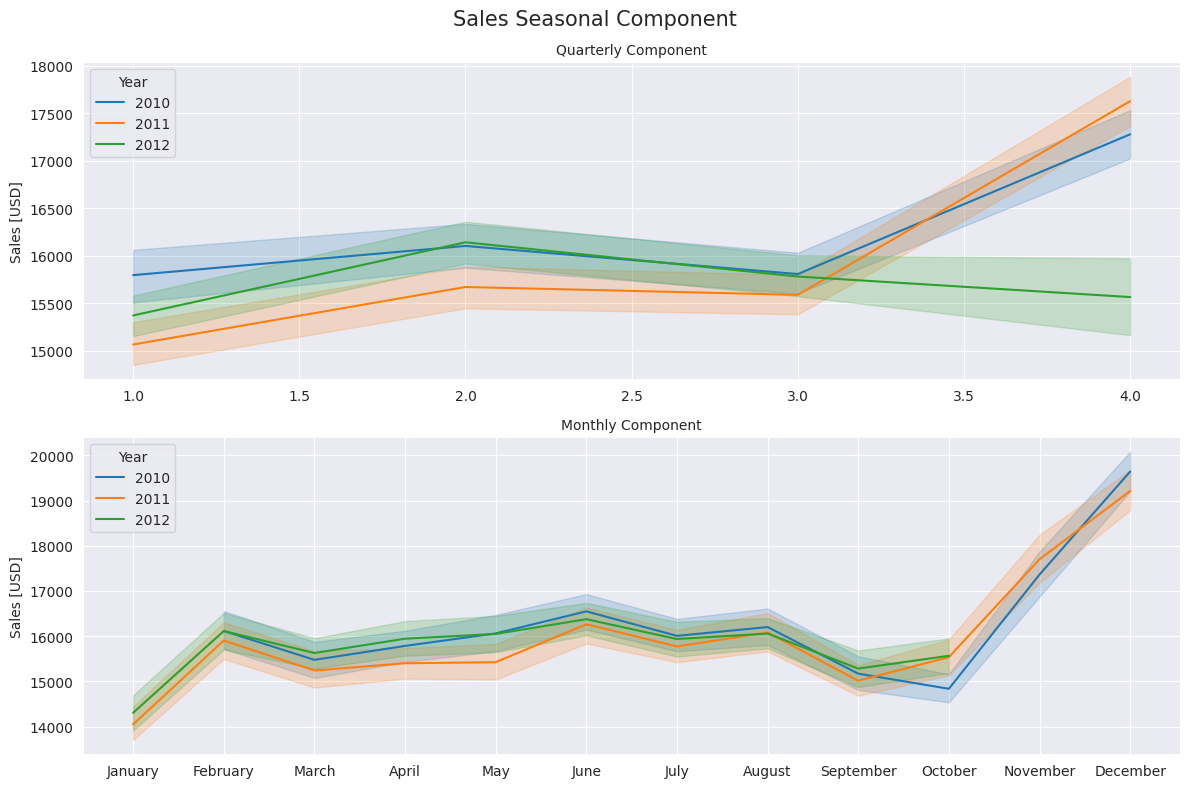

In [43]:
#plot weekly seasonal component
f, (ax1, ax2) = plt.subplots(2,1, figsize = (12, 8))

sns.lineplot(weekly_sales_comp_df, y = 'Weekly_Sales', x = 'Quarter', hue = 'Year',
             palette = sns.color_palette('tab10')[:3], ax = ax1)
sns.lineplot(weekly_sales_comp_df, y = 'Weekly_Sales', x = 'Month_Name', hue = 'Year',
             palette = sns.color_palette('tab10')[:3], ax = ax2)


ax1.set_xlabel('')
ax2.set_xlabel('')

ax1.set_ylabel('Sales [USD]')
ax2.set_ylabel('Sales [USD]')

ax1.set_title('Quarterly Component', size = 10)
ax2.set_title('Monthly Component', size = 10)

f.suptitle('Sales Seasonal Component', size = 15)
f.tight_layout()
#plt.savefig('./pyplot/sales_seasonal_comp.png')
plt.show();

### 3.3.5 Holiday Effect

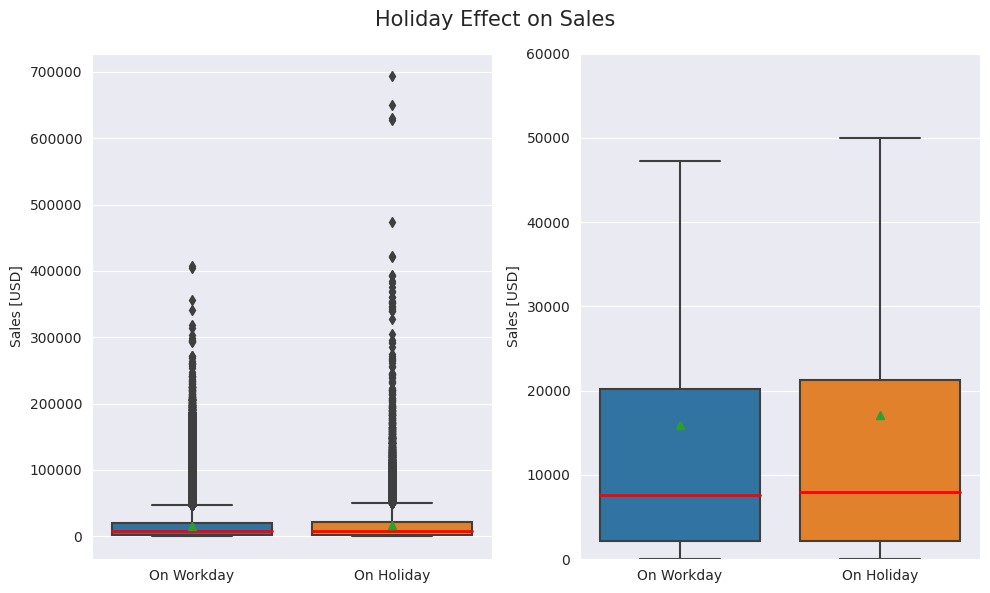

In [44]:
#set the median properties
medianprops = {'color': 'r', 'linewidth': 2, 'linestyle' : '-'}
meanprops = {'color': 'k', 'linewidth': 2, 'linestyle' : '-'}

#plot the result
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 6))

sns.boxplot(sales_df, y = 'Weekly_Sales', x = 'IsHoliday',
            showmeans = True, medianprops = medianprops, meanprops = meanprops, ax = ax1)
sns.boxplot(sales_df, y = 'Weekly_Sales', x = 'IsHoliday',
            showmeans = True, medianprops = medianprops, meanprops = meanprops, showfliers = False, ax = ax2)
ax2.set_ylim(0, 60000)

ax1.set_xticklabels(['On Workday', 'On Holiday'])
ax2.set_xticklabels(['On Workday', 'On Holiday'])

ax1.set_xlabel('')
ax2.set_xlabel('')

ax1.set_ylabel('Sales [USD]')
ax2.set_ylabel('Sales [USD]')

plt.suptitle('Holiday Effect on Sales', size = 15)
f.tight_layout()
#plt.savefig('./pyplot/holiday_effect.png')
plt.show();

**insight**

* Sales on Holiday is slightly higher compared with sales on Workday
* The distrubution of sales is mostly between 0 and 50.000 USD on weekly basis
* The highest sales was reached on holiday, with almost 700.000 USD in just a week
* A lot of sales has lies above 50.000 USD, we need to further explore the sales dataset to see maybe there are another special day which contribute sales in huge amount

### 3.3.6 Special Day Effect

In [45]:
sales_on_special_day = sales_df[sales_df['Weekly_Sales'] > 50000].groupby(by = 'Date').sum()[['Weekly_Sales']]
sales_on_special_day

Weekly_Sales
Date                    
2010-02-05   20930582.65
2010-02-12   17645380.76
2010-02-19   17490972.73
2010-02-26   15760974.72
2010-03-05   17983102.72
...                  ...
2012-09-28   15085308.63
2012-10-05   18340040.56
2012-10-12   16054714.62
2012-10-19   15453841.19
2012-10-26   15558215.64

[143 rows x 1 columns]

In [46]:
sales_on_special_day.shape

(143, 1)

There are 143 days which contributes to high sales.

In [47]:
#see the top 20 date of sales on special days
sales_on_special_day.sort_values(by='Weekly_Sales', ascending=False)[:20]

Weekly_Sales
Date                    
2010-12-24   45683428.35
2011-12-23   42488161.34
2011-11-25   34272819.26
2010-11-26   33086779.41
2010-12-17   29360473.12
2011-12-16   28090560.19
2011-12-09   23924749.61
2010-12-10   23768491.40
2012-04-06   22751049.46
2010-02-05   20930582.65
2012-07-06   20862563.59
2012-02-10   20748652.92
2012-02-17   19928703.00
2010-12-03   19464929.08
2012-06-08   19305755.47
2010-04-02   19212767.42
2011-12-02   19066731.62
2012-02-03   18995191.47
2012-09-07   18936745.36
2011-11-11   18869486.72

It seems that, special days like Christmass Day, Thanksgiving Days, Washington's Birthday, Labor's Days, etc will increase sales so high far above the others. We must consider these special days in forecasting the future sales.

# 4. Combine All Dataset

 first of all, since `sales_df` is weekly sales data for each dept in a store and `features_df` only account per stores then we need to grouping `sales_df` data into stores only.

## 4.1 Combine `sales_df` with `features_df`

In [48]:
#grouping and re arrange sales_df by Date and Store
sales_df.reset_index(inplace=True)
sales_df.drop(columns='Dept', inplace=True)
sales_df = sales_df.groupby(by=['Store', 'Date']).agg({'Weekly_Sales':'sum',
                                                       'IsHoliday':'mean'})
sales_df.sort_values(by=['Store', 'Date'], ascending=[1,1], inplace=True)

#re arrange features_df by Date and Store
features_df.reset_index(inplace=True)
features_df.sort_values(by=['Store', 'Date'], ascending=[1,1], inplace=True)

In [49]:
combined_df = pd.merge_asof(sales_df, features_df, on='Store', by='Date')
combined_df.head()

Date  Store  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0 2010-02-05      1    1643690.90          0.0        42.31       2.572   
1 2010-02-12      1    1641957.44          1.0        38.51       2.548   
2 2010-02-19      1    1612831.17          0.0        39.93       2.514   
3 2010-02-26      1    1409727.59          0.0        46.63       2.561   
4 2010-03-05      1    1554806.68          0.0        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment  IsHoliday_y  
0         8.106        False  
1         8.106         True  
2         8.106        False  
3         8.106        False  
4         8.106        False

In [50]:
sorting_list=['Date', 'IsHoliday', 'Store', 
              'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
              'Weekly_Sales']

In [51]:
#drop IsHoliday_y column
combined_df.drop(columns='IsHoliday_y', inplace=True)

#rename IsHoliday_x column
combined_df.rename(columns={'IsHoliday_x':'IsHoliday'}, inplace=True)

#re arrange columns
combined_df = combined_df[sorting_list]

In [52]:
combined_df.head()

Date  IsHoliday  Store  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0 2010-02-05        0.0      1        42.31       2.572        NaN        NaN   
1 2010-02-12        1.0      1        38.51       2.548        NaN        NaN   
2 2010-02-19        0.0      1        39.93       2.514        NaN        NaN   
3 2010-02-26        0.0      1        46.63       2.561        NaN        NaN   
4 2010-03-05        0.0      1        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  Weekly_Sales  
0        NaN        NaN        NaN  211.096358         8.106    1643690.90  
1        NaN        NaN        NaN  211.242170         8.106    1641957.44  
2        NaN        NaN        NaN  211.289143         8.106    1612831.17  
3        NaN        NaN        NaN  211.319643         8.106    1409727.59  
4        NaN        NaN        NaN  211.350143         8.106    1554806.68

In [53]:
combined_df.shape

(6435, 13)

## 4.2. Combine `combined_df` with Other the Remaining `features_df` Data

In [54]:
features_df = features_df[[i for i in sorting_list if i != 'Weekly_Sales']]
next_features_df = features_df[features_df['Date']>datetime.datetime(2012, 10, 26)]
next_features_df

Date  IsHoliday  Store  Temperature  Fuel_Price  MarkDown1  \
143  2012-11-02      False      1        55.32       3.386    6766.44   
144  2012-11-09      False      1        61.24       3.314   11421.32   
145  2012-11-16      False      1        52.92       3.252    9696.28   
146  2012-11-23       True      1        56.23       3.211     883.59   
147  2012-11-30      False      1        52.34       3.207    2460.03   
...         ...        ...    ...          ...         ...        ...   
8185 2013-06-28      False     45        76.05       3.639    4842.29   
8186 2013-07-05      False     45        77.50       3.614    9090.48   
8187 2013-07-12      False     45        79.37       3.614    3789.94   
8188 2013-07-19      False     45        82.84       3.737    2961.49   
8189 2013-07-26      False     45        76.06       3.804     212.02   

      MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  
143     5147.70      50.82    3639.90    2737.42  223.462779         6.573  
144     3370.89      40.28    4646.79    6154.16  223.481307         6.573  
145      292.10     103.78    1133.15    6612.69  223.512911         6.573  
146        4.17   74910.32     209.91     303.32  223.561947         6.573  
147         NaN    3838.35     150.57    6966.34  223.610984         6.573  
...         ...        ...        ...        ...         ...           ...  
8185     975.03       3.00    2449.97    3169.69         NaN           NaN  
8186    2268.58     582.74    5797.47    1514.93         NaN           NaN  
8187    1827.31      85.72     744.84    2150.36         NaN           NaN  
8188    1047.07     204.19     363.00    1059.46         NaN           NaN  
8189     851.73       2.06      10.88    1864.57         NaN           NaN  

[1755 rows x 12 columns]

In [55]:
df_ = pd.concat([combined_df, next_features_df], axis=0)
df_.head()

Date  IsHoliday  Store  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0 2010-02-05        0.0      1        42.31       2.572        NaN        NaN   
1 2010-02-12        1.0      1        38.51       2.548        NaN        NaN   
2 2010-02-19        0.0      1        39.93       2.514        NaN        NaN   
3 2010-02-26        0.0      1        46.63       2.561        NaN        NaN   
4 2010-03-05        0.0      1        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  Weekly_Sales  
0        NaN        NaN        NaN  211.096358         8.106    1643690.90  
1        NaN        NaN        NaN  211.242170         8.106    1641957.44  
2        NaN        NaN        NaN  211.289143         8.106    1612831.17  
3        NaN        NaN        NaN  211.319643         8.106    1409727.59  
4        NaN        NaN        NaN  211.350143         8.106    1554806.68

In [56]:
df_.shape

(8190, 13)

### 4.3 Merge with `stores_df`

In [57]:
sorting_list2=['Date', 'IsHoliday', 'Store', 'Type', 'Size',
               'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
               'Weekly_Sales']

In [58]:
df = df_.merge(stores_df, how='left')
df = df[sorting_list2]

In [59]:
df.head()

Date  IsHoliday  Store Type    Size  Temperature  Fuel_Price  \
0 2010-02-05        0.0      1    A  151315        42.31       2.572   
1 2010-02-12        1.0      1    A  151315        38.51       2.548   
2 2010-02-19        0.0      1    A  151315        39.93       2.514   
3 2010-02-26        0.0      1    A  151315        46.63       2.561   
4 2010-03-05        0.0      1    A  151315        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment  Weekly_Sales  
0         8.106    1643690.90  
1         8.106    1641957.44  
2         8.106    1612831.17  
3         8.106    1409727.59  
4         8.106    1554806.68

In [60]:
df.shape

(8190, 15)

In [61]:
feature_columns_original = df.columns[:-1]

`df` is now our data to process, we will use this data to create a model and make a prediction of sales

## 5. Data Preprosessing

## 5.1 Fill Missing Values

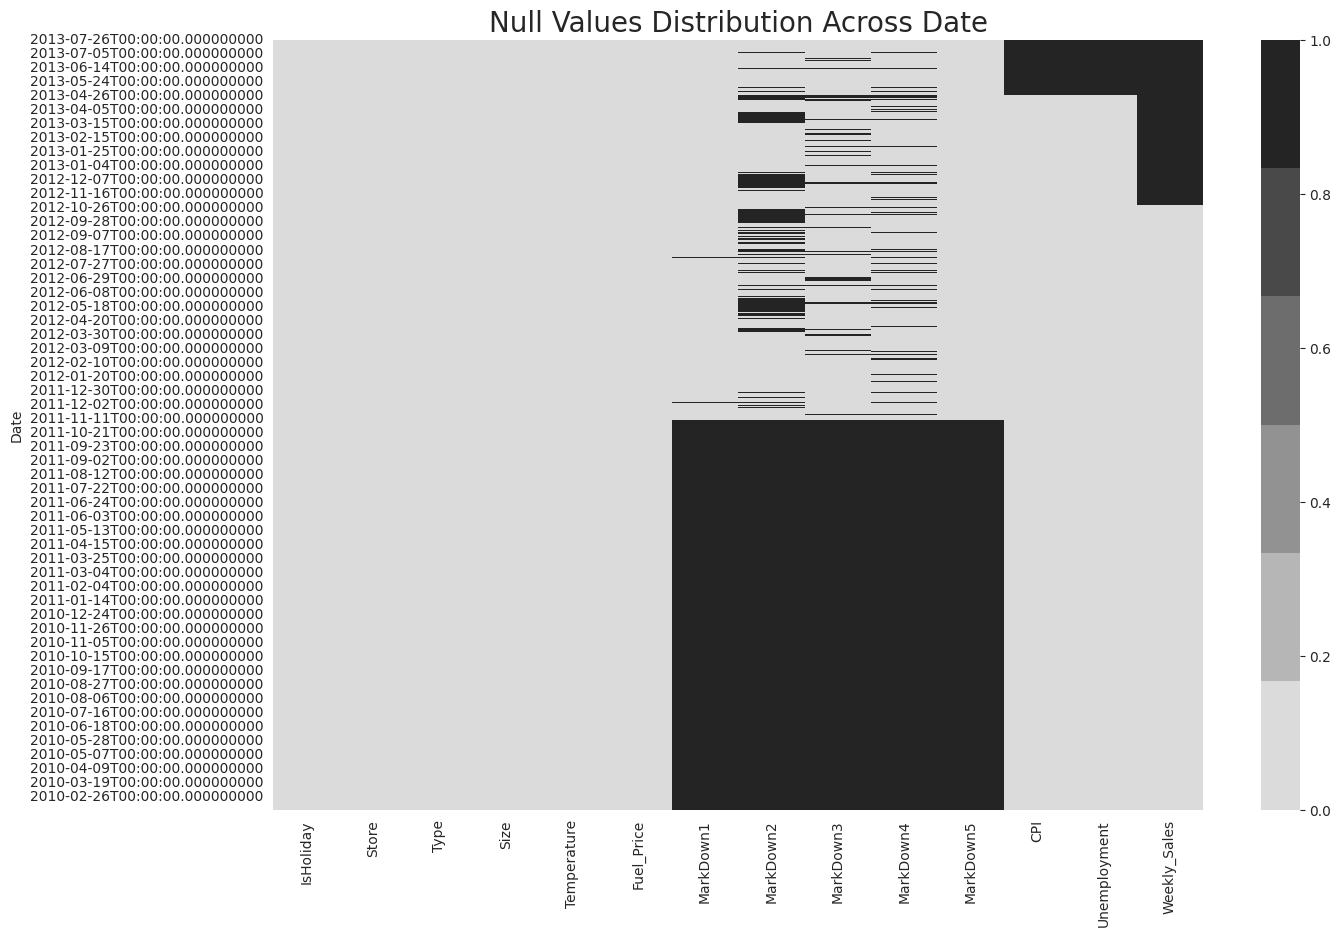

In [62]:
#lets visualize null values over time using Heatmap plot
f, ax = plt.subplots(1,1,figsize = (15,10))
sns.heatmap(df.set_index('Date').sort_index(ascending=False).isnull(),
            linecolor = 'white', cmap = sns.color_palette('binary'), ax=ax)
plt.title('Null Values Distribution Across Date', size = 20)
#plt.savefig('./pyplot/null_values_on_df.png')
plt.show();

In [63]:
check_null(df, only_null=True)

Null_QTY      %Null
MarkDown1         4158  50.769231
MarkDown2         5269  64.334554
MarkDown3         4577  55.885226
MarkDown4         4726  57.704518
MarkDown5         4140  50.549451
CPI                585   7.142857
Unemployment       585   7.142857
Weekly_Sales      1755  21.428571

* We need to fill all missing values except for `Weekly_Sales` because `Weekly_Sales` is the value that we need to estimate using our model
* on filling the missing values, we will use different appoaches since each features (MarkDown, CPI, and Unemployment) has it's own characteristic based on the findings we've found in Exploartory Data Analysis step

### 5.1.1 Filling Missing MarkDowns

we do not has more than 50% of our total MarkDown records (We don't have all MarkDown data from feb 2010 to November 2011). Luckly, we have MarkDown data on Nov 2011 to July 2013. And because MarkDown is linked to Stores and Month, we will fill our data based on median of MarkDown on different Stores and Month.

In [64]:
#expand the dates
df = expand_date(df, datetime_col = 'Date')
df.head()

Date  IsHoliday  Store Type    Size  Temperature  Fuel_Price  \
0 2010-02-05        0.0      1    A  151315        42.31       2.572   
1 2010-02-12        1.0      1    A  151315        38.51       2.548   
2 2010-02-19        0.0      1    A  151315        39.93       2.514   
3 2010-02-26        0.0      1    A  151315        46.63       2.561   
4 2010-03-05        0.0      1    A  151315        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  ...  Unemployment  Weekly_Sales  Day  \
0        NaN        NaN        NaN  ...         8.106    1643690.90    5   
1        NaN        NaN        NaN  ...         8.106    1641957.44   12   
2        NaN        NaN        NaN  ...         8.106    1612831.17   19   
3        NaN        NaN        NaN  ...         8.106    1409727.59   26   
4        NaN        NaN        NaN  ...         8.106    1554806.68    5   

   Month  Year  Month_Name  Day_Name  Week_of_Year Day_of_Year Quarter  
0      2  2010    February    Friday             5          36       1  
1      2  2010    February    Friday             6          43       1  
2      2  2010    February    Friday             7          50       1  
3      2  2010    February    Friday             8          57       1  
4      3  2010       March    Friday             9          64       1  

[5 rows x 23 columns]

In [65]:
#create dataframe that contains median values of markdown on different Month
median_markdowns = df[['Store', 'Month', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] \
                        .groupby(by=['Store', 'Month']).median().reset_index() \
                        .rename(columns={'MarkDown1' : 'MarkDown1_Med',
                                         'MarkDown2' : 'MarkDown2_Med',
                                         'MarkDown3' : 'MarkDown3_Med',
                                         'MarkDown4' : 'MarkDown4_Med',
                                         'MarkDown5' : 'MarkDown5_Med'})

median_markdowns.head()

Store  Month  MarkDown1_Med  MarkDown2_Med  MarkDown3_Med  MarkDown4_Med  \
0      1      1       3956.280       5792.665         24.445        349.850   
1      1      2      17016.405       5122.365         74.425      14335.985   
2      1      3      10320.310        151.880         10.525       1162.800   
3      1      4       3601.395        932.580         65.420        546.710   
4      1      5       6154.140         92.000         69.890       1675.490   

   MarkDown5_Med  
0       3559.795  
1       5721.630  
2       3202.405  
3       3673.680  
4       3261.040

In [66]:
def fill_markdown(df, source_df, on, fill_cols, sf='_Med'):
    #create merged dataframe
    est_markdown = pd.merge(df, source_df, on=on)
    
    #take index of Null values of dataframe and stores its values to dictionary
    dict_i = {}
    for col in fill_cols:
        dict_i[col] = est_markdown[est_markdown[col].isnull()==True].index
    
    #create for loop to fill missing values
    for k, v in dict_i.items():
        #fill missing values
        est_markdown.loc[v, k] = est_markdown.loc[v, k+sf]
        #drop columns source
        est_markdown.drop(columns = k+sf, inplace=True)
        
    #drop duplicates
    est_markdown.drop_duplicates(inplace=True)
    
    return est_markdown

In [67]:
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

#fill markdown on each stores and month
df = fill_markdown(df, median_markdowns, on=['Store', 'Month'], fill_cols=markdown_cols)

#check the result
check_null(df, only_null=True)

Null_QTY      %Null
MarkDown2          619   7.557998
MarkDown3          143   1.746032
MarkDown4          349   4.261294
CPI                585   7.142857
Unemployment       585   7.142857
Weekly_Sales      1755  21.428571

great!, we almost fill all MarkDowns with median values for each stores on different month. Let's continue to fill with median values for each store only

In [68]:
#create dataframe that contains median values of markdown on different Stores
store_median_markdowns = df[['Store', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] \
                            .groupby(by=['Store']).median().reset_index() \
                            .rename(columns={'MarkDown1' : 'MarkDown1_Med',
                                             'MarkDown2' : 'MarkDown2_Med',
                                             'MarkDown3' : 'MarkDown3_Med',
                                             'MarkDown4' : 'MarkDown4_Med',
                                             'MarkDown5' : 'MarkDown5_Med'})

store_median_markdowns.head()

Store  MarkDown1_Med  MarkDown2_Med  MarkDown3_Med  MarkDown4_Med  \
0      1       6154.140        171.250         65.420       1470.535   
1      2       7994.305        358.760         55.775       2074.330   
2      3       2462.025         81.130          8.000        411.840   
3      4       7429.460        295.680         74.875       3650.430   
4      5       2237.250         50.135         10.555        428.800   

   MarkDown5_Med  
0       3682.265  
1       4430.170  
2        861.400  
3       5279.755  
4       1735.835

In [69]:
#fill markdown on each stores and month
df = fill_markdown(df, store_median_markdowns, on=['Store'], fill_cols=markdown_cols)

#check the result
check_null(df, only_null=True)

Null_QTY      %Null
CPI                585   7.142857
Unemployment       585   7.142857
Weekly_Sales      1755  21.428571

finally, we have done to fill all MarkDown

In [70]:
df.shape

(8190, 23)

### 5.1.2 Filling Missing Unemployment and CPI

In [71]:
def fillna_lastval(df, on, fill_col):
    #iterate over on specific type to fill fill_col
    for item in df[on].unique():
        df.loc[df[df[on]==item].index, fill_col] = df.loc[df[df[on]==item].index, fill_col].fillna(method='ffill')
    return df

In [72]:
fillna_lastval(df, on='Store', fill_col='Unemployment')

Date  IsHoliday  Store Type    Size  Temperature  Fuel_Price  \
0    2010-02-05        0.0      1    A  151315        42.31       2.572   
1    2010-02-12        1.0      1    A  151315        38.51       2.548   
2    2010-02-19        0.0      1    A  151315        39.93       2.514   
3    2010-02-26        0.0      1    A  151315        46.63       2.561   
4    2010-03-05        0.0      1    A  151315        46.50       2.625   
...         ...        ...    ...  ...     ...          ...         ...   
8185 2013-06-28        0.0     45    B  118221        76.05       3.639   
8186 2013-07-05        0.0     45    B  118221        77.50       3.614   
8187 2013-07-12        0.0     45    B  118221        79.37       3.614   
8188 2013-07-19        0.0     45    B  118221        82.84       3.737   
8189 2013-07-26        0.0     45    B  118221        76.06       3.804   

      MarkDown1  MarkDown2  MarkDown3  ...  Unemployment  Weekly_Sales  Day  \
0     17016.405   5122.365     74.425  ...         8.106    1643690.90    5   
1     17016.405   5122.365     74.425  ...         8.106    1641957.44   12   
2     17016.405   5122.365     74.425  ...         8.106    1612831.17   19   
3     17016.405   5122.365     74.425  ...         8.106    1409727.59   26   
4     10320.310    151.880     10.525  ...         8.106    1554806.68    5   
...         ...        ...        ...  ...           ...           ...  ...   
8185   4842.290    975.030      3.000  ...         8.335           NaN   28   
8186   9090.480   2268.580    582.740  ...         8.335           NaN    5   
8187   3789.940   1827.310     85.720  ...         8.335           NaN   12   
8188   2961.490   1047.070    204.190  ...         8.335           NaN   19   
8189    212.020    851.730      2.060  ...         8.335           NaN   26   

      Month  Year  Month_Name  Day_Name  Week_of_Year Day_of_Year Quarter  
0         2  2010    February    Friday             5          36       1  
1         2  2010    February    Friday             6          43       1  
2         2  2010    February    Friday             7          50       1  
3         2  2010    February    Friday             8          57       1  
4         3  2010       March    Friday             9          64       1  
...     ...   ...         ...       ...           ...         ...     ...  
8185      6  2013        June    Friday            26         179       2  
8186      7  2013        July    Friday            27         186       3  
8187      7  2013        July    Friday            28         193       3  
8188      7  2013        July    Friday            29         200       3  
8189      7  2013        July    Friday            30         207       3  

[8190 rows x 23 columns]

In [73]:
fillna_lastval(df, on='Store', fill_col='CPI')

Date  IsHoliday  Store Type    Size  Temperature  Fuel_Price  \
0    2010-02-05        0.0      1    A  151315        42.31       2.572   
1    2010-02-12        1.0      1    A  151315        38.51       2.548   
2    2010-02-19        0.0      1    A  151315        39.93       2.514   
3    2010-02-26        0.0      1    A  151315        46.63       2.561   
4    2010-03-05        0.0      1    A  151315        46.50       2.625   
...         ...        ...    ...  ...     ...          ...         ...   
8185 2013-06-28        0.0     45    B  118221        76.05       3.639   
8186 2013-07-05        0.0     45    B  118221        77.50       3.614   
8187 2013-07-12        0.0     45    B  118221        79.37       3.614   
8188 2013-07-19        0.0     45    B  118221        82.84       3.737   
8189 2013-07-26        0.0     45    B  118221        76.06       3.804   

      MarkDown1  MarkDown2  MarkDown3  ...  Unemployment  Weekly_Sales  Day  \
0     17016.405   5122.365     74.425  ...         8.106    1643690.90    5   
1     17016.405   5122.365     74.425  ...         8.106    1641957.44   12   
2     17016.405   5122.365     74.425  ...         8.106    1612831.17   19   
3     17016.405   5122.365     74.425  ...         8.106    1409727.59   26   
4     10320.310    151.880     10.525  ...         8.106    1554806.68    5   
...         ...        ...        ...  ...           ...           ...  ...   
8185   4842.290    975.030      3.000  ...         8.335           NaN   28   
8186   9090.480   2268.580    582.740  ...         8.335           NaN    5   
8187   3789.940   1827.310     85.720  ...         8.335           NaN   12   
8188   2961.490   1047.070    204.190  ...         8.335           NaN   19   
8189    212.020    851.730      2.060  ...         8.335           NaN   26   

      Month  Year  Month_Name  Day_Name  Week_of_Year Day_of_Year Quarter  
0         2  2010    February    Friday             5          36       1  
1         2  2010    February    Friday             6          43       1  
2         2  2010    February    Friday             7          50       1  
3         2  2010    February    Friday             8          57       1  
4         3  2010       March    Friday             9          64       1  
...     ...   ...         ...       ...           ...         ...     ...  
8185      6  2013        June    Friday            26         179       2  
8186      7  2013        July    Friday            27         186       3  
8187      7  2013        July    Friday            28         193       3  
8188      7  2013        July    Friday            29         200       3  
8189      7  2013        July    Friday            30         207       3  

[8190 rows x 23 columns]

In [74]:
check_null(df, only_null=True)

Null_QTY      %Null
Weekly_Sales      1755  21.428571

Horay!!, we have done all imputation of missing values.

## 5.2 Check for Duplicated Data (If Any)

In [75]:
#check for duplicates
df[df.duplicated()==True]

Empty DataFrame
Columns: [Date, IsHoliday, Store, Type, Size, Temperature, Fuel_Price, MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5, CPI, Unemployment, Weekly_Sales, Day, Month, Year, Month_Name, Day_Name, Week_of_Year, Day_of_Year, Quarter]
Index: []

[0 rows x 23 columns]

There's no duplicated data

## 5.3 Feature Engineering

### 5.3.1 Create Dummy Variables from Categorical Data

Since `Type` and `Month` has great impact on determining the weekly sales, we will create this dummies from this. And for stores, we will not make dummies from it because we assume that it is already represented by size in the form of numerical values. With this assumtion, we can reduce the number of column of our dataset

In [76]:
#create dummies for Type and Month
df['Month'] = 'Month_'+df['Month'].astype(str)

#create dummies
month_dummies = pd.get_dummies(df['Month'])

### 5.3.2 Create Dummy Variables from Special Dates

#### A. Take a Look Into Global Sales Data and Set Upper and Lower Limit of Special Day

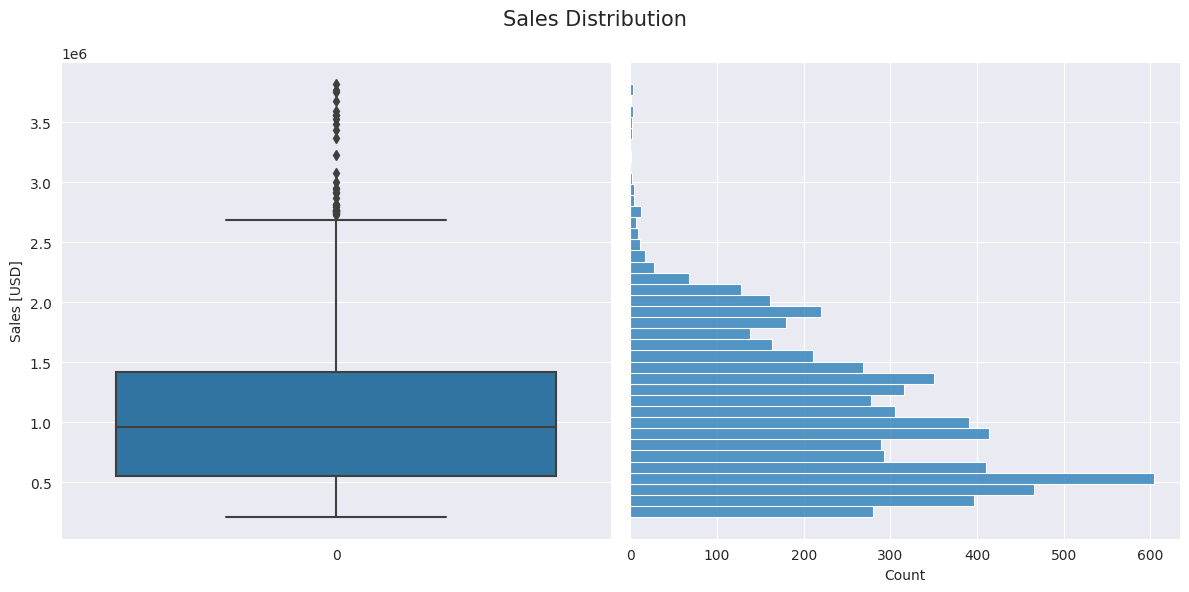

In [77]:
#plot weekly_sales distribution to see the outliers
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6), sharey=True)

sns.boxplot(df['Weekly_Sales'], ax=ax1)
sns.histplot(df[['Weekly_Sales']], y='Weekly_Sales' ,ax=ax2)

f.suptitle('Sales Distribution', size=15)
ax1.set_ylabel('Sales [USD]')
ax2.set_ylabel('')
f.tight_layout()
#plt.savefig('./sales_dist.png')
plt.show();

It can be seen that outliers lays form 2.600.000 USD to 4.000.000 USD. But, Data is right skewed herefore we assume that `Weekly_Sales` above 2.000.000 is considered high sales due to the effect of special days. And for Data below 400000 are considered as low sales due to the effect of special days.
Therefore we will create upper and lower limit of Sales Data

In [78]:
upperlimit = 2500000

#### B. Decide Special Days to Be Included in The Model

As we know, special dates like maybe like christmas, thanksgiving, labor day or others special dates could increase sales significantly. So we need to take it into new features to check what types of special date on each record. This is paramount step on time series analysis and can't not be neglected. And because *Walmart stores are already distributed especially in United States, Mexico, United Kingdom, and African country we also need to gather as many special dates as possible from these countries and do filter our data so we only consider some days that looks improve sales significantly*. To do so, we will utilize `holidays` module to collect the holidays date on countries of interest rather than scraping and searching manually through internet.

#####  B.1 Create DataFrame of Special Days using Holidays Module

In [79]:
#make list of years
years = [2010, 2011, 2012, 2013]

#create datafreme contains all holidays
special_dates = holidays.US(years=years)+holidays.MX(years=years)+holidays.UK(years=years)+holidays.ZA(years=years)
special_dates_df = pd.DataFrame({
    'Date' : special_dates.keys(),
    'Special_Day' : special_dates.values()
})

#change date into datetime format
special_dates_df['Date'] = pd.to_datetime(special_dates_df['Date'])

#make year, we will see why this is important
special_dates_df['Year'] = special_dates_df['Date'].dt.year

#sort date
special_dates_df.sort_values(by='Date', ascending=True, inplace=True)

#re arange dataframe
special_dates_df = special_dates_df[['Date','Year','Special_Day']]
special_dates_df.reset_index(drop=True, inplace=True)

#see the result
print(f'Total length of DataFrame : {len(special_dates_df)} records')
print(f'Total special days        : {len(special_dates_df.Special_Day.unique())} unique days')

special_dates_df

Total length of DataFrame : 142 records
Total special days        : 53 unique days


Date  Year                             Special_Day
0   2010-01-01  2010               Año Nuevo; New Year's Day
1   2010-01-02  2010             New Year Holiday [Scotland]
2   2010-01-04  2010  New Year Holiday [Scotland] (Observed)
3   2010-01-18  2010              Martin Luther King Jr. Day
4   2010-02-01  2010                  Día de la Constitución
..         ...   ...                                     ...
137 2013-11-28  2013                            Thanksgiving
138 2013-11-30  2013             St. Andrew's Day [Scotland]
139 2013-12-16  2013                   Day of Reconciliation
140 2013-12-25  2013                  Christmas Day; Navidad
141 2013-12-26  2013             Boxing Day; Day of Goodwill

[142 rows x 3 columns]

It's hard to edit the Holiday DataFrame in Python, not only it will take more time and effort but also it will make our code looks messy (Looks it has 44 unique days and also complex styling). Since it has only 116 records, for more fancy ways, I consider to edit it in Ms. Excell

In [80]:
#we can save the DataFrame using these command below and edit it in Ms Excell

'''
special_dates_df.to_csv('/kaggle/input/walmart-sales-prediction-dataset/special_days.csv')
'''

"\nspecial_dates_df.to_csv('/kaggle/input/walmart-sales-prediction-dataset/special_days.csv')\n"

In [81]:
#after some modification and editing, we get:
special_dates_df = pd.read_csv('/kaggle/input/walmart-sales-prediction-dataset/special_days.csv', delimiter=';')
special_dates_df['Date'] = pd.to_datetime(special_dates_df['Date'], dayfirst=True)
special_dates_df.sort_values(by='Date')
special_dates_df

Date  Year                    Special_Day
0  2010-01-01  2010                       New Year
1  2010-01-18  2010     Martin Luther King Jr. Day
2  2010-02-01  2010  Day of Constitution of Mexico
3  2010-02-15  2010          Washington's Birthday
4  2010-03-15  2010         Birth of Benito Juarez
..        ...   ...                            ...
91 2013-11-11  2013                   Veterans Day
92 2013-11-18  2013          Mexico Revolucion Day
93 2013-11-28  2013                   Thanksgiving
94 2013-12-16  2013          Day of Reconciliation
95 2013-12-24  2013                  Christmas Day

[96 rows x 3 columns]

##### B.2 Create Days Connector

   Days connector is only dataframe to help me joined `df` with its corresponding holidays event in `special_dates_df`. The reason why is becaused `pd.merge_asof()` algorithm works to find the nearest match in sorted DataFrame and `df` contains more than one unique date, if we do not use connector, it will result in wrong join of DataFrame.

In [82]:
#create connector to link the dates
df_connector = df[['Date', 'Year']].groupby(by='Date').mean() \
                .reset_index().sort_values(by='Date', ascending=True).astype({'Year':'int64'})

#link it to Special Day's name
df_connector = pd.merge_asof(df_connector, special_dates_df, on='Date', by='Year')

#add the actual dates, this is where 'Year' column is usefull
df_connector = pd.merge(df_connector, special_dates_df, on=['Special_Day', 'Year'],
                        suffixes=('','_of_Celebration'))

#add day different between date of celebration and data
df_connector['Day_Diff'] = df_connector['Date']-df_connector['Date_of_Celebration']

#show the result
df_connector

Date  Year                    Special_Day Date_of_Celebration  \
0   2010-02-05  2010  Day of Constitution of Mexico          2010-02-01   
1   2010-02-12  2010  Day of Constitution of Mexico          2010-02-01   
2   2010-02-19  2010          Washington's Birthday          2010-02-15   
3   2010-02-26  2010          Washington's Birthday          2010-02-15   
4   2010-03-05  2010          Washington's Birthday          2010-02-15   
..         ...   ...                            ...                 ...   
177 2013-06-28  2013                      Youth Day          2013-06-16   
178 2013-07-05  2013               Independence Day          2013-07-04   
179 2013-07-12  2013               Independence Day          2013-07-04   
180 2013-07-19  2013               Independence Day          2013-07-04   
181 2013-07-26  2013               Independence Day          2013-07-04   

    Day_Diff  
0     4 days  
1    11 days  
2     4 days  
3    11 days  
4    18 days  
..       ...  
177  12 days  
178   1 days  
179   8 days  
180  15 days  
181  22 days  

[182 rows x 5 columns]

##### B.3 Merge with `df`

Join `df` with `df_connector`, and get the result

In [83]:
df = pd.merge(df, df_connector, on=['Date', 'Year'])
df.head()

Date  IsHoliday  Store Type    Size  Temperature  Fuel_Price  \
0 2010-02-05        0.0      1    A  151315        42.31       2.572   
1 2010-02-12        1.0      1    A  151315        38.51       2.548   
2 2010-02-19        0.0      1    A  151315        39.93       2.514   
3 2010-02-26        0.0      1    A  151315        46.63       2.561   
4 2010-03-05        0.0      1    A  151315        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  ...    Month  Year  Month_Name  Day_Name  \
0  17016.405   5122.365     74.425  ...  Month_2  2010    February    Friday   
1  17016.405   5122.365     74.425  ...  Month_2  2010    February    Friday   
2  17016.405   5122.365     74.425  ...  Month_2  2010    February    Friday   
3  17016.405   5122.365     74.425  ...  Month_2  2010    February    Friday   
4  10320.310    151.880     10.525  ...  Month_3  2010       March    Friday   

   Week_of_Year  Day_of_Year Quarter                    Special_Day  \
0             5           36       1  Day of Constitution of Mexico   
1             6           43       1  Day of Constitution of Mexico   
2             7           50       1          Washington's Birthday   
3             8           57       1          Washington's Birthday   
4             9           64       1          Washington's Birthday   

  Date_of_Celebration Day_Diff  
0          2010-02-01   4 days  
1          2010-02-01  11 days  
2          2010-02-15   4 days  
3          2010-02-15  11 days  
4          2010-02-15  18 days  

[5 rows x 26 columns]

##### B.4  Remove Sales Days That Aren't Significantly Influenced by The Event of Special Day

We need to choose only small number of Dates that really has strong effect on sales. To do so, we choose only sales that we consider it as outliers based on our sales distribution chart and select only sales that has max 7 day-different (this is because we work on summed weekly sales data).

In [84]:
special_day = df[df['Weekly_Sales'].notnull()==True]

In [85]:
#the condition where Special Days doen't has strong influence towards sales are:
#first: sales is on regular sales bigger than upperlimit
condition1 = special_day[special_day['Weekly_Sales']<upperlimit].index

#second: days of sales is more than a week
condition2 = special_day[special_day['Day_Diff']>datetime.timedelta(7)].index

In [86]:
#remove special days from df where conditions are met
special_day.loc[condition1, 'Special_Day'] = np.nan
special_day.loc[condition2, 'Special_Day'] = np.nan

In [87]:
special_days = special_day[special_day['Special_Day'].notnull()==True][['Date','Special_Day','Day_Diff','Weekly_Sales']]
special_days

Date                    Special_Day Day_Diff  Weekly_Sales
185  2010-11-26                   Thanksgiving   1 days    2658884.29
188  2010-12-17          Day of Reconciliation   1 days    2609166.75
189  2010-12-24                  Christmas Day   0 days    3436154.68
237  2011-11-25                   Thanksgiving   1 days    2614202.30
241  2011-12-23          Day of Reconciliation   7 days    3224369.80
471  2010-11-26                   Thanksgiving   1 days    2789469.45
474  2010-12-17          Day of Reconciliation   1 days    2740057.14
475  2010-12-24                  Christmas Day   0 days    3526713.39
523  2011-11-25                   Thanksgiving   1 days    3004702.33
526  2011-12-16          Day of Reconciliation   0 days    2771397.17
527  2011-12-23          Day of Reconciliation   7 days    3676388.98
761  2010-12-24                  Christmas Day   0 days    2727575.18
813  2011-12-23          Day of Reconciliation   7 days    2644633.02
1329 2010-11-26                   Thanksgiving   1 days    2939946.38
1332 2010-12-17          Day of Reconciliation   1 days    2811687.85
1333 2010-12-24                  Christmas Day   0 days    3749057.69
1381 2011-11-25                   Thanksgiving   1 days    2950198.64
1384 2011-12-16          Day of Reconciliation   0 days    2555031.18
1385 2011-12-23          Day of Reconciliation   7 days    3487986.89
1758 2010-11-26                   Thanksgiving   1 days    2766400.05
1761 2010-12-17          Day of Reconciliation   1 days    2771646.81
1762 2010-12-24                  Christmas Day   0 days    3595903.20
1810 2011-11-25                   Thanksgiving   1 days    2864170.61
1813 2011-12-16          Day of Reconciliation   0 days    2760346.71
1814 2011-12-23          Day of Reconciliation   7 days    3556766.03
1859 2010-02-05  Day of Constitution of Mexico   4 days    2623469.95
1901 2010-11-26                   Thanksgiving   1 days    2921709.71
1904 2010-12-17          Day of Reconciliation   1 days    2762861.41
1905 2010-12-24                  Christmas Day   0 days    3818686.45
1953 2011-11-25                   Thanksgiving   1 days    2685351.81
1956 2011-12-16          Day of Reconciliation   0 days    2594363.09
1957 2011-12-23          Day of Reconciliation   7 days    3369127.99
2620 2010-12-24                  Christmas Day   0 days    2678206.42
2759 2010-11-26                   Thanksgiving   1 days    2811634.04
2762 2010-12-17          Day of Reconciliation   1 days    2819193.17
2763 2010-12-24                  Christmas Day   0 days    3766687.43
2811 2011-11-25                   Thanksgiving   1 days    2906255.28
2814 2011-12-16          Day of Reconciliation   0 days    2762818.62
2815 2011-12-23          Day of Reconciliation   7 days    3555379.47
2830 2012-04-06                    Good Friday   0 days    2565259.92
3192 2010-12-24                  Christmas Day   0 days    2734277.10
3244 2011-12-23          Day of Reconciliation   7 days    2588072.32
3760 2010-11-26                   Thanksgiving   1 days    2627910.75
3764 2010-12-24                  Christmas Day   0 days    3078162.08
3812 2011-11-25                   Thanksgiving   1 days    2504400.71
3816 2011-12-23          Day of Reconciliation   7 days    2739019.75
5532 2011-12-23          Day of Reconciliation   7 days    2554482.84

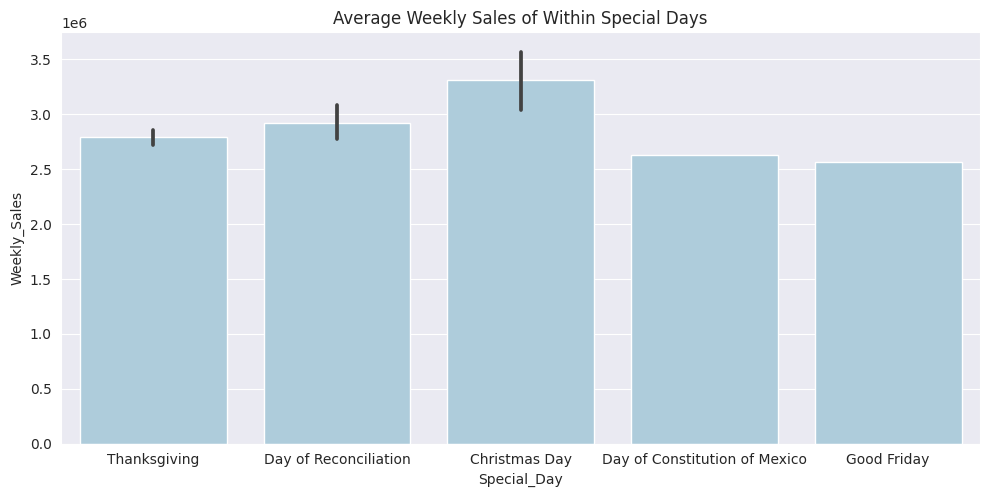

In [88]:
f, ax = plt.subplots(1,1,figsize=(10,5))

sns.barplot(special_days, 
            x='Special_Day', y='Weekly_Sales', 
            color=sns.color_palette('Paired')[0],
            estimator = 'mean',
            errorbar = ('ci', 95),
            ax=ax)

f.tight_layout()
plt.title('Average Weekly Sales of Within Special Days')
#plt.savefig('./pyplot/Average_Weekly_Sales_Within_Special_Days.png')
plt.show();

From above long journey of findings days that has significant influence on Sales, *intuitively*, we end up with 4 days:
1. Christmas Day
2. Day of Reconciliation
3. Thanksgiving Day
4. Day of Constitution of Mexico
5. Good Friday

In [89]:
#save special dates into a list
special_days_list = list(special_days.Special_Day.unique())
special_days_list

['Thanksgiving',
 'Day of Reconciliation',
 'Christmas Day',
 'Day of Constitution of Mexico',
 'Good Friday']

#### C. Dummy Variables Creation

In [90]:
#remove all special days outside special_days_list
df['Special_Day'] = df['Special_Day'].apply(lambda x: x if x in special_days_list else np.nan)

In [91]:
#create special days dummies
special_day_dummies = pd.get_dummies(df['Special_Day'])
special_day_dummies

Christmas Day  Day of Constitution of Mexico  Day of Reconciliation  \
0             False                           True                  False   
1             False                           True                  False   
2             False                          False                  False   
3             False                          False                  False   
4             False                          False                  False   
...             ...                            ...                    ...   
8185          False                          False                  False   
8186          False                          False                  False   
8187          False                          False                  False   
8188          False                          False                  False   
8189          False                          False                  False   

      Good Friday  Thanksgiving  
0           False         False  
1           False         False  
2           False         False  
3           False         False  
4           False         False  
...           ...           ...  
8185        False         False  
8186        False         False  
8187        False         False  
8188        False         False  
8189        False         False  

[8190 rows x 5 columns]

### 5.3.3 Combine Dummies into `df`

In [92]:
df = pd.concat([df, month_dummies, special_day_dummies], axis = 1)
df

Date  IsHoliday  Store Type    Size  Temperature  Fuel_Price  \
0    2010-02-05        0.0      1    A  151315        42.31       2.572   
1    2010-02-12        1.0      1    A  151315        38.51       2.548   
2    2010-02-19        0.0      1    A  151315        39.93       2.514   
3    2010-02-26        0.0      1    A  151315        46.63       2.561   
4    2010-03-05        0.0      1    A  151315        46.50       2.625   
...         ...        ...    ...  ...     ...          ...         ...   
8185 2013-06-28        0.0     45    B  118221        76.05       3.639   
8186 2013-07-05        0.0     45    B  118221        77.50       3.614   
8187 2013-07-12        0.0     45    B  118221        79.37       3.614   
8188 2013-07-19        0.0     45    B  118221        82.84       3.737   
8189 2013-07-26        0.0     45    B  118221        76.06       3.804   

      MarkDown1  MarkDown2  MarkDown3  ...  Month_5  Month_6  Month_7  \
0     17016.405   5122.365     74.425  ...    False    False    False   
1     17016.405   5122.365     74.425  ...    False    False    False   
2     17016.405   5122.365     74.425  ...    False    False    False   
3     17016.405   5122.365     74.425  ...    False    False    False   
4     10320.310    151.880     10.525  ...    False    False    False   
...         ...        ...        ...  ...      ...      ...      ...   
8185   4842.290    975.030      3.000  ...    False     True    False   
8186   9090.480   2268.580    582.740  ...    False    False     True   
8187   3789.940   1827.310     85.720  ...    False    False     True   
8188   2961.490   1047.070    204.190  ...    False    False     True   
8189    212.020    851.730      2.060  ...    False    False     True   

      Month_8  Month_9  Christmas Day Day of Constitution of Mexico  \
0       False    False          False                          True   
1       False    False          False                          True   
2       False    False          False                         False   
3       False    False          False                         False   
4       False    False          False                         False   
...       ...      ...            ...                           ...   
8185    False    False          False                         False   
8186    False    False          False                         False   
8187    False    False          False                         False   
8188    False    False          False                         False   
8189    False    False          False                         False   

      Day of Reconciliation Good Friday Thanksgiving  
0                     False       False        False  
1                     False       False        False  
2                     False       False        False  
3                     False       False        False  
4                     False       False        False  
...                     ...         ...          ...  
8185                  False       False        False  
8186                  False       False        False  
8187                  False       False        False  
8188                  False       False        False  
8189                  False       False        False  

[8190 rows x 43 columns]

### 5.3.4 Create Medium Sales

It's is woth to Try to include medium sales on dataframe since it may give historical information about the size sales in the past.

In [93]:
#create sales median df 
sales_median_df = df[['Store','Month','Weekly_Sales']].groupby(by=['Store', 'Month']) \
                    .agg({'Weekly_Sales': (lambda x : np.nanmedian(x))}).reset_index()
sales_median_df

Store     Month  Weekly_Sales
0        1   Month_1   1392703.900
1        1  Month_10   1494023.930
2        1  Month_11   1573299.085
3        1  Month_12   1741148.320
4        1   Month_2   1639148.545
..     ...       ...           ...
535     45   Month_5    797367.675
536     45   Month_6    814395.170
537     45   Month_7    745030.225
538     45   Month_8    724188.430
539     45   Month_9    716987.580

[540 rows x 3 columns]

In [94]:
df = pd.merge(df, sales_median_df, on=['Store','Month'], suffixes=('','_Median'))

In [95]:
df.drop(columns=['Month','Month_Name','Day_Name','Date_of_Celebration','Day_Diff'],inplace=True)

In [96]:
df.head()

Date  IsHoliday  Store Type    Size  Temperature  Fuel_Price  \
0 2010-02-05        0.0      1    A  151315        42.31       2.572   
1 2010-02-12        1.0      1    A  151315        38.51       2.548   
2 2010-02-19        0.0      1    A  151315        39.93       2.514   
3 2010-02-26        0.0      1    A  151315        46.63       2.561   
4 2010-03-05        0.0      1    A  151315        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  ...  Month_6  Month_7  Month_8  Month_9  \
0  17016.405   5122.365     74.425  ...    False    False    False    False   
1  17016.405   5122.365     74.425  ...    False    False    False    False   
2  17016.405   5122.365     74.425  ...    False    False    False    False   
3  17016.405   5122.365     74.425  ...    False    False    False    False   
4  10320.310    151.880     10.525  ...    False    False    False    False   

   Christmas Day  Day of Constitution of Mexico  Day of Reconciliation  \
0          False                           True                  False   
1          False                           True                  False   
2          False                          False                  False   
3          False                          False                  False   
4          False                          False                  False   

   Good Friday  Thanksgiving  Weekly_Sales_Median  
0        False         False          1639148.545  
1        False         False          1639148.545  
2        False         False          1639148.545  
3        False         False          1639148.545  
4        False         False          1554806.680  

[5 rows x 39 columns]

## 5.4 Select Features to Include in Model

In [97]:
df.sort_values(by='Date', inplace=True)
df.head()

Date  IsHoliday  Store Type    Size  Temperature  Fuel_Price  \
0    2010-02-05        0.0      1    A  151315        42.31       2.572   
5148 2010-02-05        0.0     37    C   39910        45.97       2.572   
5577 2010-02-05        0.0     40    A  155083        14.48       2.788   
4576 2010-02-05        0.0     33    A   39690        58.40       2.962   
3289 2010-02-05        0.0     24    A  203819        22.43       2.954   

      MarkDown1  MarkDown2  MarkDown3  ...  Month_6  Month_7  Month_8  \
0     17016.405   5122.365     74.425  ...    False    False    False   
5148    840.515     44.615     11.370  ...    False    False    False   
5577  13139.870   2641.385     63.035  ...    False    False    False   
4576    615.250    119.275      3.900  ...    False    False    False   
3289  14411.365   4183.380     73.290  ...    False    False    False   

      Month_9  Christmas Day  Day of Constitution of Mexico  \
0       False          False                           True   
5148    False          False                           True   
5577    False          False                           True   
4576    False          False                           True   
3289    False          False                           True   

      Day of Reconciliation  Good Friday  Thanksgiving  Weekly_Sales_Median  
0                     False        False         False          1639148.545  
5148                  False        False         False           528447.080  
5577                  False        False         False           943638.905  
4576                  False        False         False           270447.205  
3289                  False        False         False          1333805.350  

[5 rows x 39 columns]

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8190 entries, 0 to 8189
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           8190 non-null   datetime64[ns]
 1   IsHoliday                      8190 non-null   float64       
 2   Store                          8190 non-null   int64         
 3   Type                           8190 non-null   object        
 4   Size                           8190 non-null   int64         
 5   Temperature                    8190 non-null   float64       
 6   Fuel_Price                     8190 non-null   float64       
 7   MarkDown1                      8190 non-null   float64       
 8   MarkDown2                      8190 non-null   float64       
 9   MarkDown3                      8190 non-null   float64       
 10  MarkDown4                      8190 non-null   float64       
 11  MarkDown5             

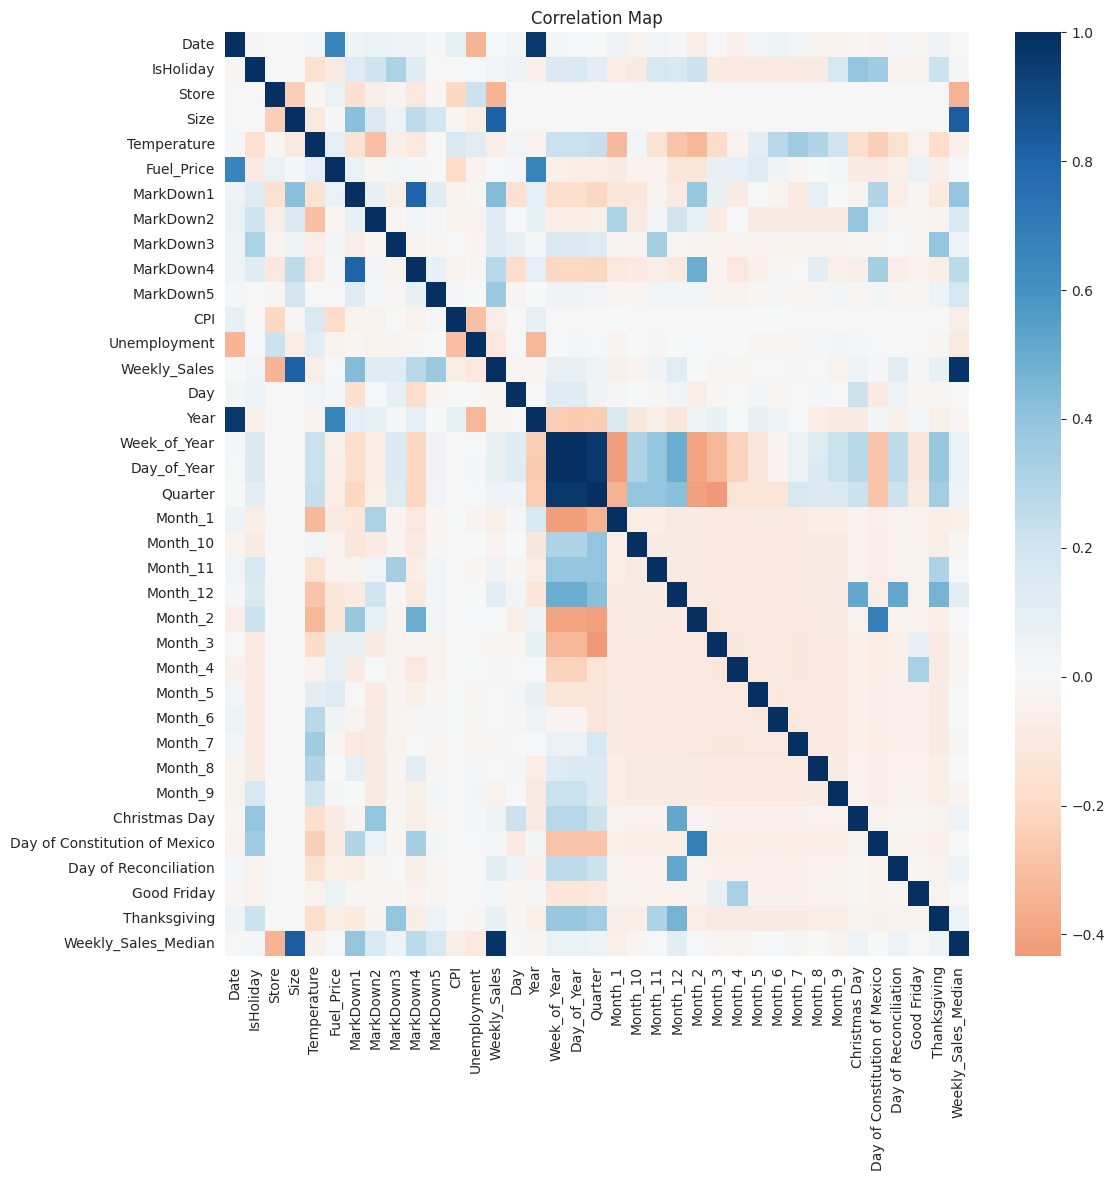

In [99]:
f, ax = plt.subplots(1,1,figsize=(12,12))

corr = df.select_dtypes(exclude='O').corr()
sns.heatmap(corr, cmap = 'RdBu', center=0, ax=ax)

plt.title('Correlation Map')
#plt.savefig('./pyplot/heatmap.png')
plt.show()

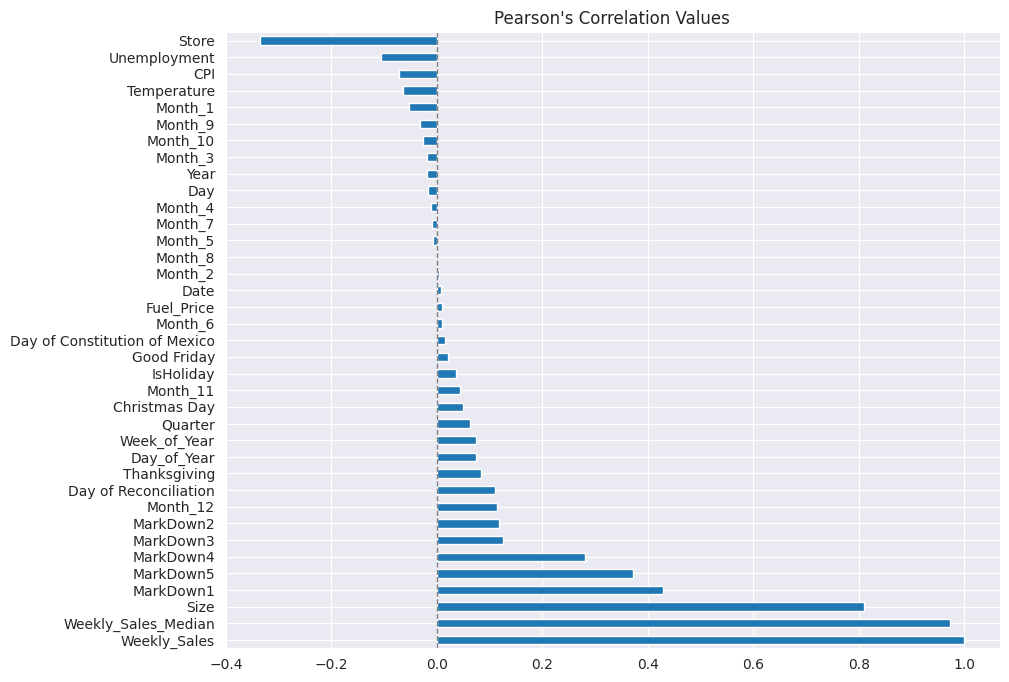

In [100]:
f, ax = plt.subplots(1,1)
corr['Weekly_Sales'].sort_values(ascending=False).plot(kind='barh',
                                                       figsize=(10,8), ax=ax)
ax.axvline(0, linestyle='--', linewidth=1, color='gray')
plt.title("Pearson's Correlation Values")
#plt.savefig('./pyplot/pearson_corr_rank.png')
plt.show();

In [101]:
keys = [#this is usefull to save key information of dataset
        'Date',
        'Store',
        'Type',
        'Special_Day']

selected = [ #store information
             'Size',

             #MarkDown Strategies
             'MarkDown1',
             'MarkDown2',
             'MarkDown3',
             'MarkDown4',
             'MarkDown5',

             #date informaion
             'IsHoliday',
             'Month_1',
             'Month_2',
             'Month_3',
             'Month_4',
             'Month_5',
             'Month_6',
             'Month_7',
             'Month_8',
             'Month_9',
             'Month_10',
             'Month_11',
             'Month_12',
             'Day of Reconciliation',
             'Christmas Day',
             'Thanksgiving',
             'Day of Constitution of Mexico',
             'Good Friday',

             #external information
             'CPI',
             'Fuel_Price',
             'Temperature',
             'Unemployment',

             #expirience
             'Weekly_Sales_Median',

             #Target
             'Weekly_Sales']

features = [i for i in selected if i!='Weekly_Sales']

target = ['Weekly_Sales']

keys_features_target = keys+features+target

In [102]:
df_selected = df[keys_features_target]
df_selected.head()

Date  Store Type                    Special_Day    Size  MarkDown1  \
0    2010-02-05      1    A  Day of Constitution of Mexico  151315  17016.405   
5148 2010-02-05     37    C  Day of Constitution of Mexico   39910    840.515   
5577 2010-02-05     40    A  Day of Constitution of Mexico  155083  13139.870   
4576 2010-02-05     33    A  Day of Constitution of Mexico   39690    615.250   
3289 2010-02-05     24    A  Day of Constitution of Mexico  203819  14411.365   

      MarkDown2  MarkDown3  MarkDown4  MarkDown5  ...  Christmas Day  \
0      5122.365     74.425  14335.985   5721.630  ...          False   
5148     44.615     11.370    132.220   1276.845  ...          False   
5577   2641.385     63.035   7858.625   5295.275  ...          False   
4576    119.275      3.900      2.610    952.055  ...          False   
3289   4183.380     73.290  19902.540   5524.505  ...          False   

      Thanksgiving  Day of Constitution of Mexico  Good Friday         CPI  \
0            False                           True        False  211.096358   
5148         False                           True        False  209.852966   
5577         False                           True        False  131.527903   
4576         False                           True        False  126.442065   
3289         False                           True        False  131.527903   

      Fuel_Price  Temperature  Unemployment  Weekly_Sales_Median  Weekly_Sales  
0          2.572        42.31         8.106          1639148.545    1643690.90  
5148       2.572        45.97         8.554           528447.080     536006.73  
5577       2.788        14.48         5.892           943638.905    1001943.80  
4576       2.962        58.40        10.115           270447.205     274593.43  
3289       2.954        22.43         8.326          1333805.350    1388725.63  

[5 rows x 34 columns]

## 5.4 Create Training and Testing, and Prediction Data

### 5.4.1 Separate Prediction Data from Training and Testing

In [103]:
#create dataset for training and testing
train_test_df = df_selected[df_selected['Weekly_Sales'].notnull()==True]

#create dataset to predict future
X_df = df_selected[df_selected['Weekly_Sales'].isnull()==True].drop(columns=['Weekly_Sales'])

In [104]:
#check for size
print(f'train and test shape: {train_test_df.shape}')
print(f'prediction shape: {X_df.shape}')

train and test shape: (6435, 34)
prediction shape: (1755, 33)


### 5.4.2 Separate Training and Testing Data

In [105]:
train_test = train_test_df.to_numpy()
train_test_cols = train_test_df.columns

In [106]:
#split into training and testing dataset
train_set, test_set = np.split(train_test, [int(.67*len(train_test))])

#get X and y values of training and testing dataset
X_train, X_test, y_train, y_test = train_set[:,4:-1].astype('float'), test_set[:,4:-1].astype('float'), train_set[:,-1].astype('float'), test_set[:,-1].astype('float')

#get X_test keys for comparison
X_test_keys = test_set[:,:4] 

In [107]:
X_test_keys.shape, X_test.shape, y_test.shape

((2124, 4), (2124, 29), (2124,))

In [108]:
X = X_df.to_numpy()

X_keys = X[:,:4]
X_features = X[:,4:]

In [109]:
X_keys.shape, X_features.shape

((1755, 4), (1755, 29))

# 6. Create Machine Learning Model (Linear Regression)

In [110]:
scaler = PowerTransformer()

linreg = LinearRegression()
RFreg = RandomForestRegressor()
GBreg = GradientBoostingRegressor()
DTreg = DecisionTreeRegressor()

tss = TimeSeriesSplit(n_splits=5)

model_scoring = ('r2','neg_mean_absolute_error','neg_root_mean_squared_error','neg_mean_absolute_percentage_error')

## 6.1 Linear Regression

In [111]:
linreg_pipe = Pipeline([('scaler',scaler),('Linreg_model',linreg)])

In [112]:
linreg_val_scores = cross_validate(linreg_pipe, X_train, y_train, 
                                   cv=tss, scoring=model_scoring,
                                   error_score=np.nan)

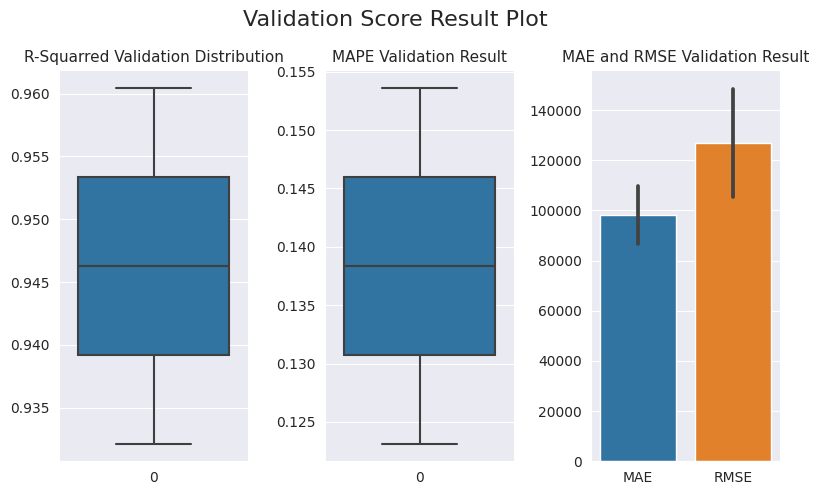

In [113]:
linreg_val_scores_df = see_val_score(linreg_val_scores, model_name='Linear Regression',figsize=(8,5))

In [114]:
linreg_pred = linreg_pipe.fit(X_train, y_train).predict(X_test)

Evaluation Matrics Scores
RMSE : 1222590.35
MAE  : 147788.33
MAPE : 0.17


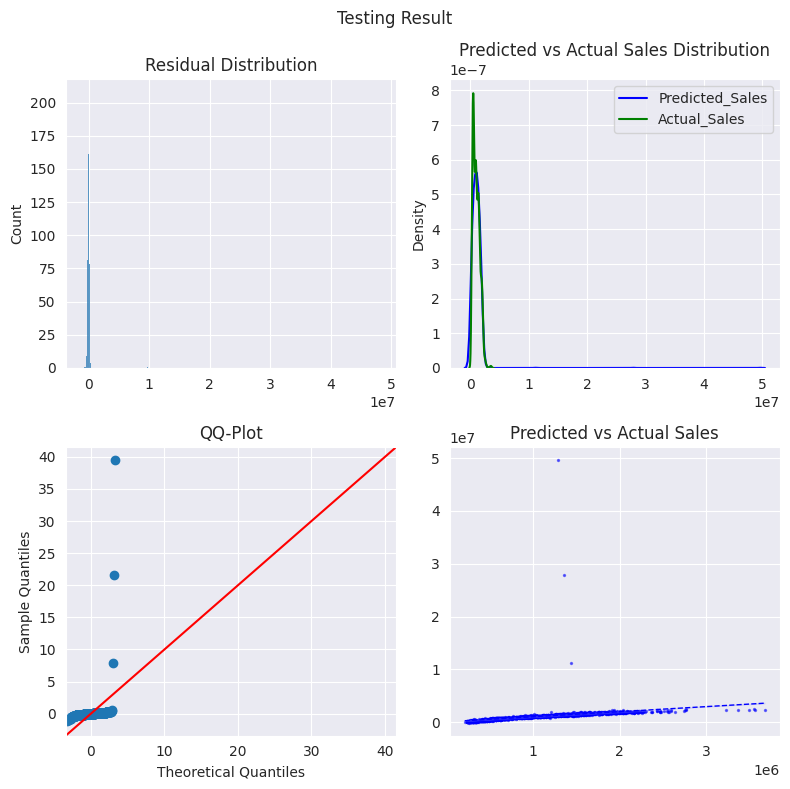

In [115]:
model_evaluation(linreg_pred, y_test)

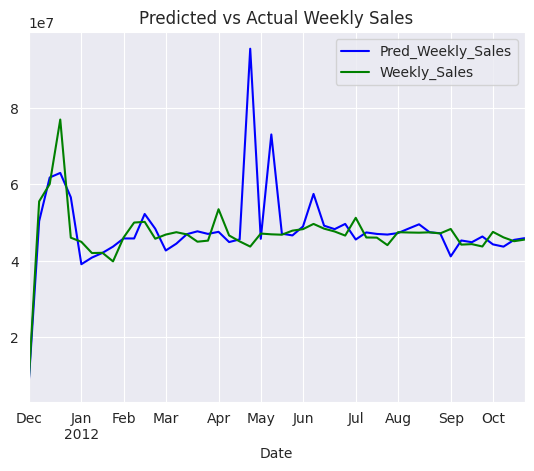

In [116]:
linreg_test_df = return_test_result(test_keys = X_test_keys, 
                                    test_features = X_test, 
                                    y_test = y_test,
                                    columns = keys_features_target,
                                    ypred_test = linreg_pred,
                                    plot=True, future_pred=False)

## 6.2 Random Forest Regressor

In [117]:
RFreg_pipe = Pipeline([('scaler',scaler),('RFreg_model',RFreg)])

In [118]:
RFreg_val_scores = cross_validate(RFreg_pipe, X_train, y_train, cv=tss, scoring=model_scoring)

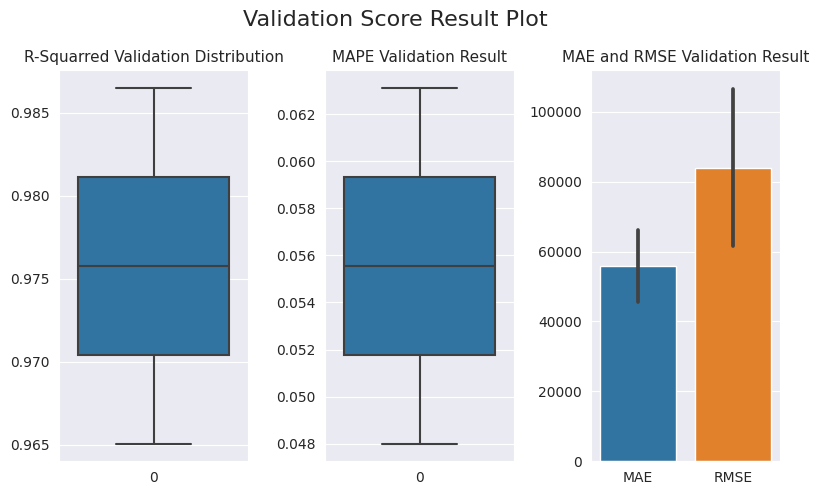

In [119]:
RFreg_val_scores_df = see_val_score(RFreg_val_scores, figsize=(8,5), model_name='Random Forest')

In [120]:
RFreg_pred = RFreg_pipe.fit(X_train, y_train).predict(X_test)

Evaluation Matrics Scores
RMSE : 111957.89
MAE  : 68022.56
MAPE : 0.06


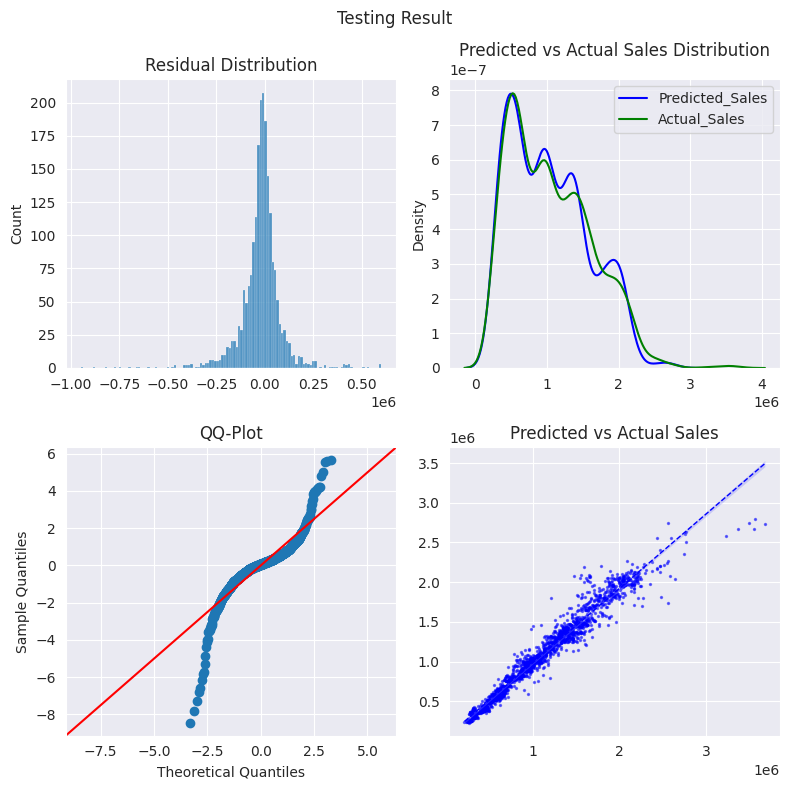

In [121]:
model_evaluation(RFreg_pred, y_test)

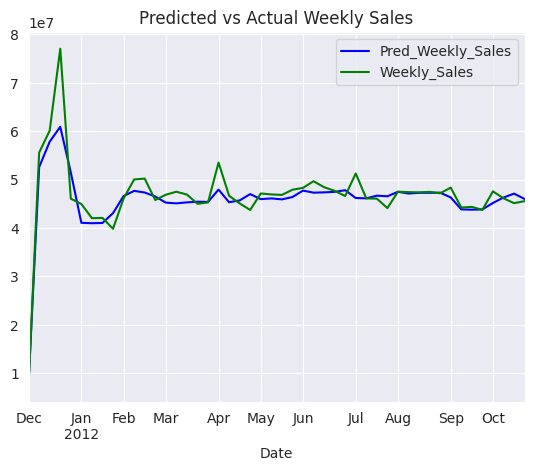

In [122]:
RFreg_test_df = return_test_result(test_keys = X_test_keys, 
                                    test_features = X_test, 
                                    y_test = y_test,
                                    columns = keys_features_target,
                                    ypred_test = RFreg_pred,  
                                    plot=True, future_pred=False)

## 6.3 Gradient Boosting Regressor

In [123]:
GBreg_pipe = Pipeline([('scaler',scaler),('GBreg_model',GBreg)])

In [124]:
GBreg_val_scores = cross_validate(GBreg_pipe, X_train, y_train, cv=tss, scoring=model_scoring)

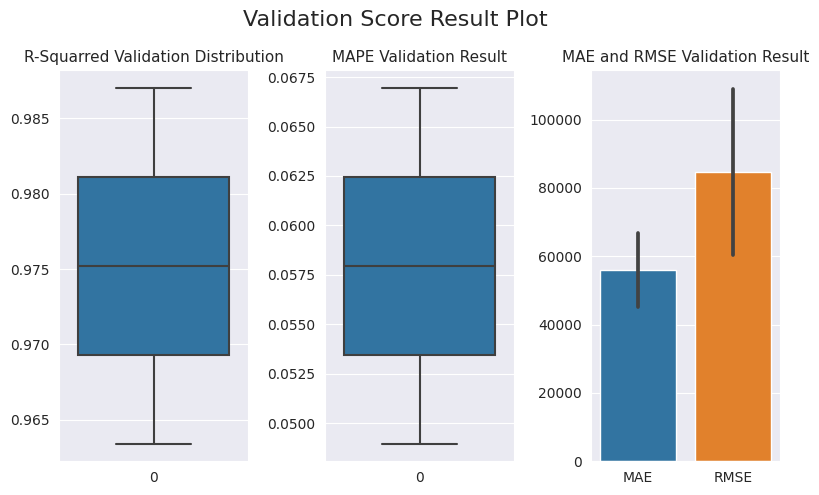

In [125]:
GBreg_val_scores_df = see_val_score(GBreg_val_scores, figsize=(8,5), model_name='Gradient Boosting')

In [126]:
GBreg_pred = GBreg_pipe.fit(X_train, y_train).predict(X_test)

Evaluation Matrics Scores
RMSE : 104210.92
MAE  : 64116.17
MAPE : 0.06


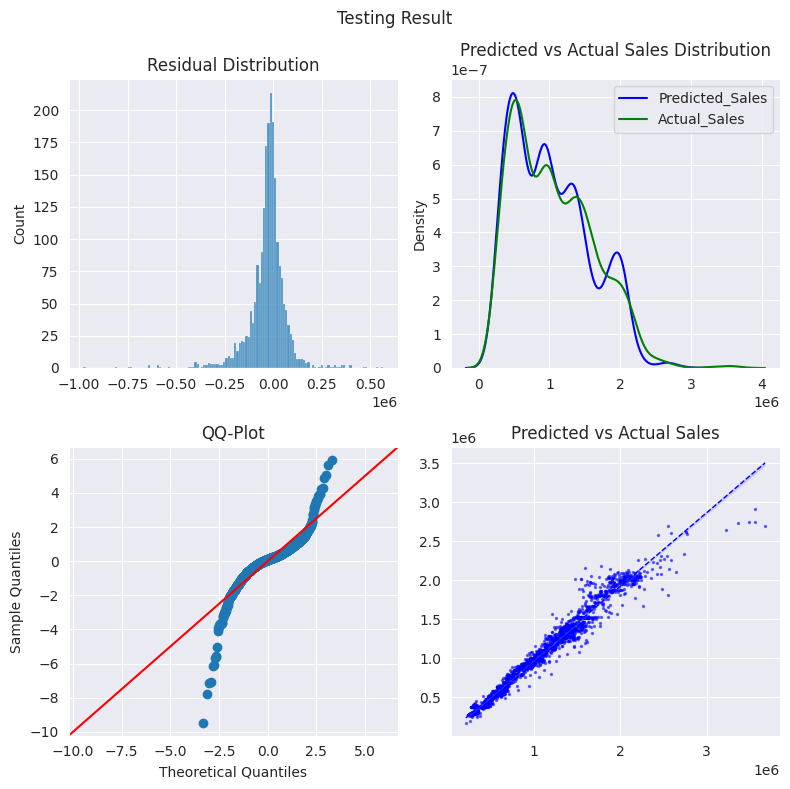

In [127]:
model_evaluation(GBreg_pred, y_test)

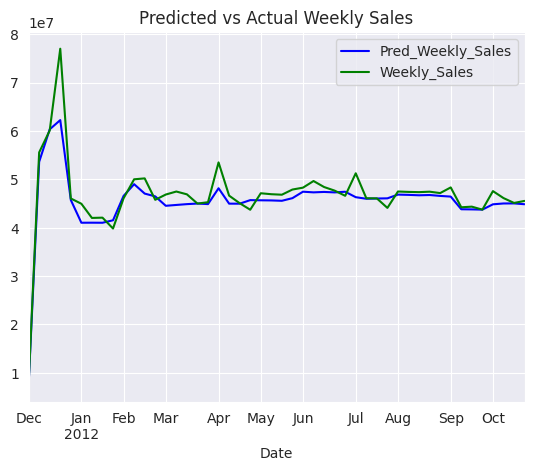

In [128]:
GBreg_test_df = return_test_result(test_keys = X_test_keys, 
                                    test_features = X_test, 
                                    y_test = y_test, 
                                    columns = keys_features_target,
                                    ypred_test = GBreg_pred,   
                                    plot=True, future_pred=False)

## 6.4 Decision Tree Regressor

In [129]:
DTreg_pipe = Pipeline([('scaler',scaler),('DTreg_model',DTreg)])

In [130]:
DTreg_val_scores = cross_validate(DTreg_pipe, X_train, y_train, cv=tss, scoring=model_scoring)

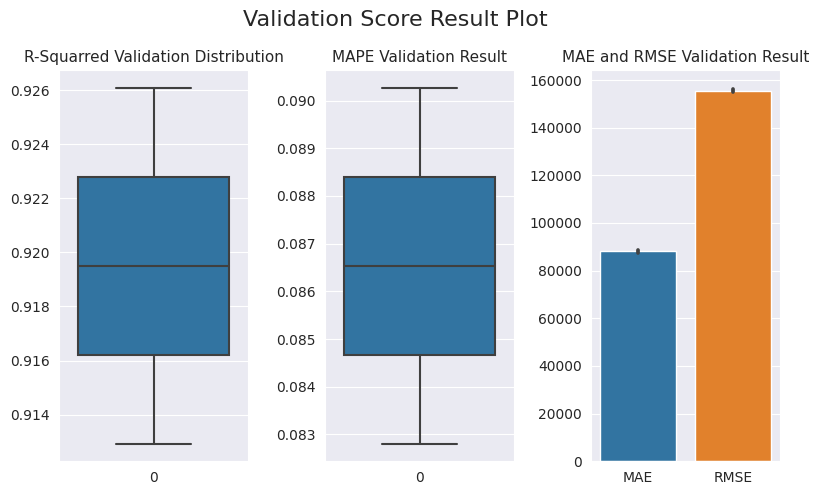

In [131]:
DTreg_val_scores_df = see_val_score(DTreg_val_scores, figsize=(8,5), model_name='Decision Tree')

In [132]:
DTreg_pred = DTreg_pipe.fit(X_train, y_train).predict(X_test)

Evaluation Matrics Scores
RMSE : 184740.71
MAE  : 104859.03
MAPE : 0.11


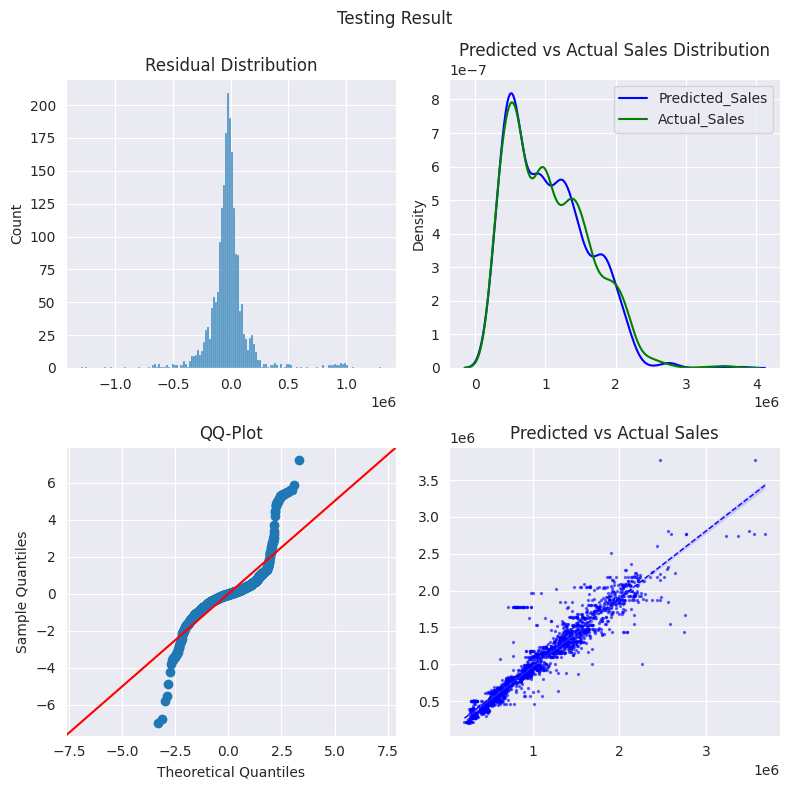

In [133]:
model_evaluation(DTreg_pred, y_test)

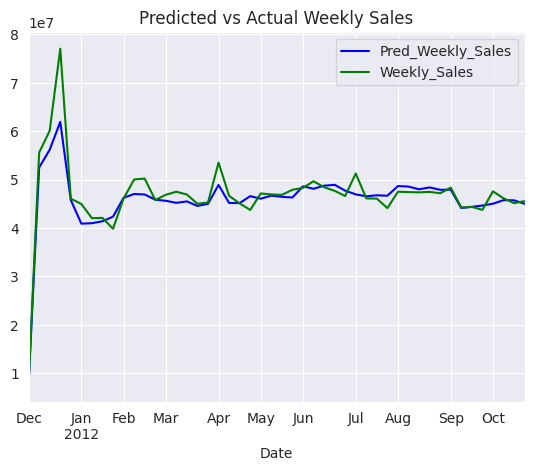

In [134]:
DTreg_test_df = return_test_result(test_keys = X_test_keys, 
                                    test_features = X_test, 
                                    y_test = y_test,
                                    columns = keys_features_target,
                                    ypred_test = DTreg_pred, 
                                    plot=True, future_pred=False)

## 6.5 Model Selection

In [135]:
model_eval_result = pd.concat([linreg_val_scores_df,RFreg_val_scores_df,GBreg_val_scores_df,DTreg_val_scores_df], axis=0).reset_index(drop=True)

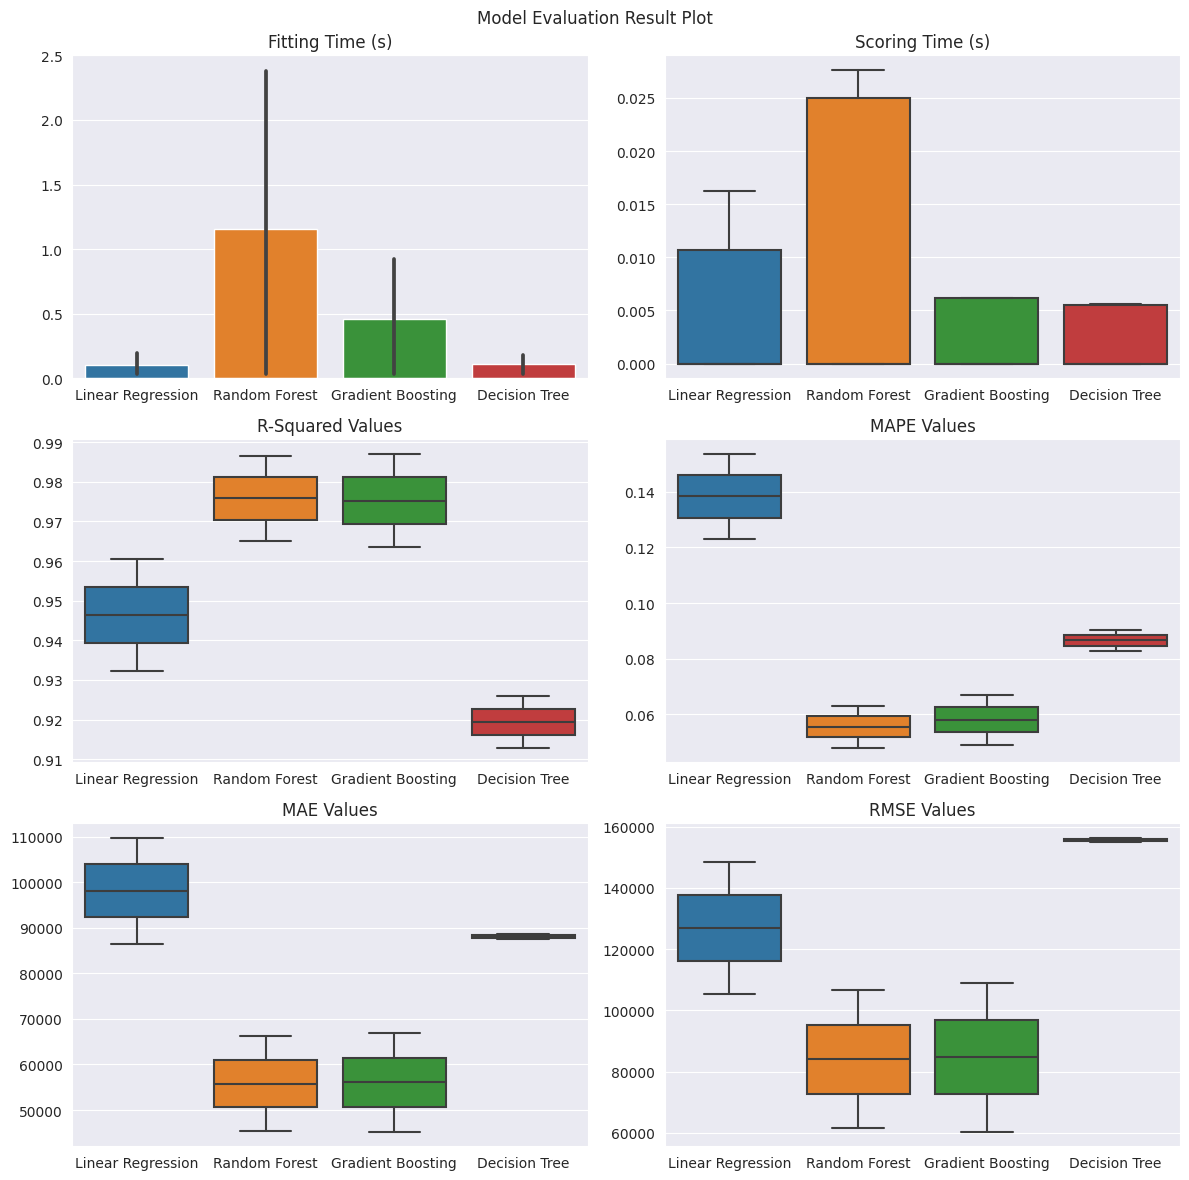

In [136]:
f, ax = plt.subplots(3,2,figsize=(12,12))

f.suptitle('Model Evaluation Result Plot')

ax[0,0].set_title('Fitting Time (s)')
sns.barplot(model_eval_result,
            x='Model', y='fit_time',
            ax = ax[0,0])
ax[0,0].set_ylabel('')
ax[0,0].set_xlabel('')

ax[0,1].set_title('Scoring Time (s)')
sns.boxplot(model_eval_result,
            x='Model', y='score_time',
            ax = ax[0,1])
ax[0,1].set_ylabel('')
ax[0,1].set_xlabel('')

ax[1,0].set_title('R-Squared Values')
sns.boxplot(model_eval_result,
            x='Model', y='R-Squared',
            ax = ax[1,0])
ax[1,0].set_ylabel('')
ax[1,0].set_xlabel('')

ax[1,1].set_title('MAPE Values')
sns.boxplot(model_eval_result,
            x='Model', y='MAPE',
            ax = ax[1,1])
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel('')

ax[2,0].set_title('MAE Values')
sns.boxplot(model_eval_result,
            x='Model', y='MAE',
            ax = ax[2,0])
ax[2,0].set_ylabel('')
ax[2,0].set_xlabel('')

ax[2,1].set_title('RMSE Values')
sns.boxplot(model_eval_result,
            x='Model', y='RMSE',
            ax = ax[2,1])
ax[2,1].set_ylabel('')
ax[2,1].set_xlabel('')

f.tight_layout()
plt.show()

From the result above, we choose Gradient Boosting Algorithm as our model since it has high R^Squared Values and it has Lower Loss compared to Linear Regression, and Decision Tree Algorith, and also it is faster than random forest.

# 7. Future Sales Prediction

In [137]:
GBreg_pred_future = GBreg_pipe.fit(train_test[:,4:-1], train_test[:,-1]).predict(X_features)

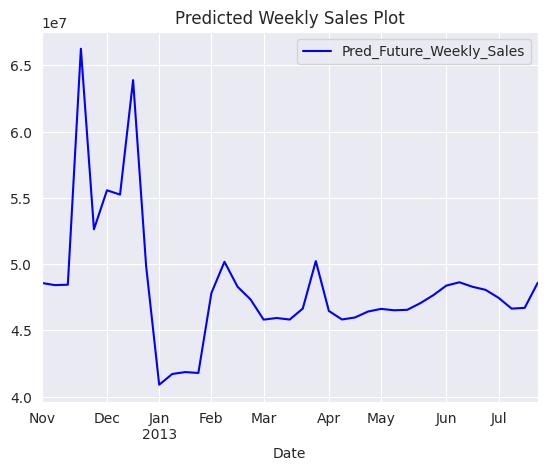

In [138]:
future_pred_df = return_test_result(test_keys = X_keys, 
                                    test_features = X_features, 
                                    y_test = None, 
                                    ypred_test = GBreg_pred_future,
                                    columns = keys+features,
                                    pred_column = 'Pred_Future_Weekly_Sales',
                                    plot=True, future_pred=True)

In [139]:
walmart_future_sales_pred_df = future_pred_df[list(feature_columns_original)+['Pred_Future_Weekly_Sales']]
walmart_future_sales_pred_df

Date IsHoliday Store Type    Size Temperature Fuel_Price MarkDown1  \
0    2012-11-02       0.0     9    B  125833       56.26      3.386   2291.26   
1    2012-11-02       0.0    33    A   39690       70.96      4.099     43.69   
2    2012-11-02       0.0    34    A  158114       50.91      3.404   3189.15   
3    2012-11-02       0.0     8    A  155078       53.41      3.386   8753.34   
4    2012-11-02       0.0    35    B  103681       54.44      3.787   9427.41   
...         ...       ...   ...  ...     ...         ...        ...       ...   
1750 2013-07-26       0.0    26    A  152513       63.07      3.879    538.78   
1751 2013-07-26       0.0    25    B  128107       68.72      3.804    242.98   
1752 2013-07-26       0.0    12    B  112238       90.27      3.865   1008.91   
1753 2013-07-26       0.0    33    A   39690       89.73      3.865      9.79   
1754 2013-07-26       0.0    45    B  118221       76.06      3.804    212.02   

     MarkDown2 MarkDown3 MarkDown4 MarkDown5         CPI Unemployment  \
0      2178.48     65.25     20.52   1347.79  227.251326        4.954   
1       294.09      5.06     4.715     561.2  131.236226        6.895   
2      2375.99     31.62   1270.88   2705.65  131.236226        8.839   
3       2732.6       6.3   1715.26   2261.91  227.055455        5.124   
4      3322.67      31.3   3119.64   1982.11   142.66146        8.665   
...        ...       ...       ...       ...         ...          ...   
1750    822.92       0.4     85.49   1086.05  139.122613        6.884   
1751    891.49       1.8     47.23   1129.68  217.742295        7.191   
1752    232.99       6.0    284.49   2132.08  132.716097        9.874   
1753   119.275      2.02       3.9    500.03  132.716097        6.698   
1754    851.73      2.06     10.88   1864.57  193.589304        8.335   

     Pred_Future_Weekly_Sales  
0               558496.007635  
1               289297.914777  
2              1001544.729672  
3                946710.70312  
4               902050.184997  
...                       ...  
1750           1035177.378724  
1751            688496.176946  
1752            948363.570125  
1753            292729.361684  
1754            733495.521134  

[1755 rows x 15 columns]

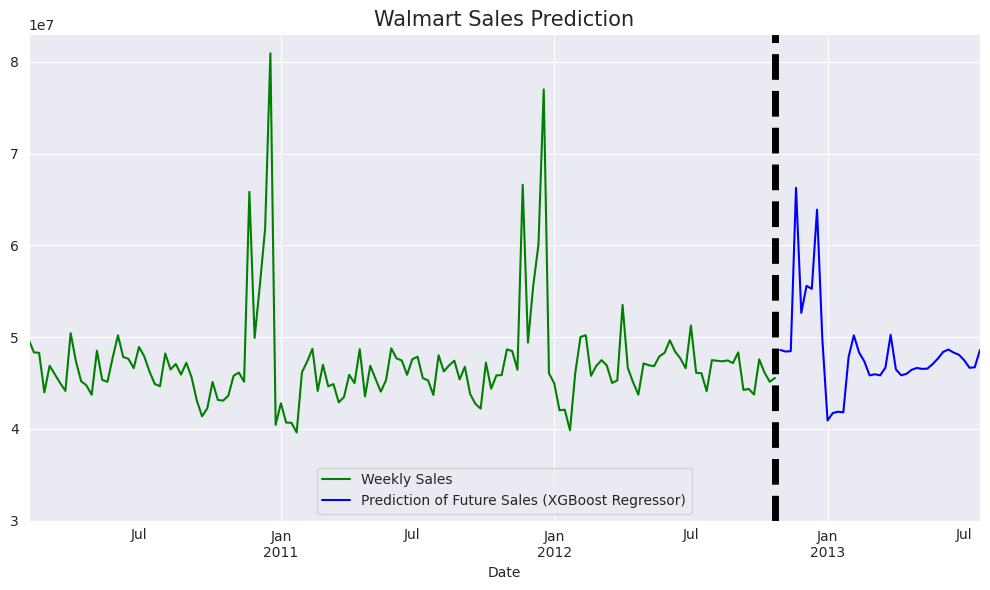

In [140]:
f, ax = plt.subplots(1,1,figsize=(10,6))


ax.set_title('Walmart Sales Prediction', size=15)

train_test_df[['Date','Weekly_Sales']].groupby(by='Date').sum().plot(color = 'g',
                                                                     ax=ax)
walmart_future_sales_pred_df[['Date','Pred_Future_Weekly_Sales']].groupby(by='Date').sum().plot(color = 'b',
                                                                                                ax=ax)

ax.set_ylim(bottom = 30000000)
ax.axvline(x=datetime.datetime(2012,10,26), color ='k', lw = 5, linestyle='--')
ax.legend(['Weekly Sales', 'Prediction of Future Sales (XGBoost Regressor)'],
          loc='lower center',
          bbox_to_anchor=(.5, 0))

f.tight_layout()
plt.show()